# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных:

- **Хост** — ...
- **База данных** — 
- **Порт** — ...
- **Аутентификация** — ...
- **Пользователь** — ...
- **Пароль** — ...

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


 Устанавливаю необходимые библиотеки:
 - SQLAlchemy
 - psycopg2

In [1]:
#!pip install sqlalchemy
#!pip install psycopg2-binary

In [3]:
#!pip install python-dotenv

Импортирую необходимые библиотеки и и функцию create_engine()  из библиотеки SQLAlchemy для подключения к базе данных и выполнения SQL-запроса:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine

Импортирую билбиотеки для работы с .env файлом, хранящим чувствительные данные

In [2]:
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

True

Запишем данные для подключения к базе данных `data-analyst-afisha` в объект db_config:

In [4]:
db_config = {
    'user': os.getenv('USER'),
    'pwd': os.getenv('PASSWORD'),
    'host': os.getenv('HOST'),
    'port': os.getenv('PORT'),
    'db': os.getenv('DB')
}

In [10]:
# Чувствительные данные вынесены в .env файл. Для примера структуры используется .env.example в папке проекта

Формирую строку для подключения, которая содержит информацию об используемой СУБД, а также все данные для авторизации:

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Строку с данными для подключения передаю функции create_engine():

In [6]:
engine = create_engine(connection_string)

Запрос запишем в переменную query:

In [7]:
query = '''
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count,
       EXTRACT(DAY FROM created_dt_msk - LAG(created_dt_msk)OVER(PARTITION BY user_id ORDER BY created_dt_msk ASC)) AS days_since_prev,
       p.event_id,
       e.event_name_code AS event_name,
       e.event_type_main,
       p.service_name,
       (SELECT region_name FROM afisha.regions r WHERE r.region_id = c.region_id),
       c.city_name
FROM afisha.purchases p 
JOIN afisha.events e USING (event_id)
JOIN afisha.city c USING (city_id)
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id 
''' 

Результат выдачи SQL-запроса запишем в датафрейм, переменную <u>df</u>:

In [8]:
df = pd.read_sql_query(query, con=engine)

OperationalError: (psycopg2.OperationalError) connection to server at "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net" (158.160.77.5), port 6432 failed: ERROR:  odyssey: cb026db56ec49: user blocked: data-analyst-afisha maria

(Background on this error at: https://sqlalche.me/e/14/e3q8)

Создаю копию датасета до преобразований:

In [8]:
tmp = df.copy()
initial_len_df = len(tmp)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Вывожу первые пять строк датафрейма для обзора:

In [9]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Информация о названиях столбцов и проверка, все ли необходимые столбцы выгружены согласно заданию:

In [10]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name'],
      dtype='object')

Названия и требуемая в задании информация выгружены корректно.

Общая информация о полученном датафрейме:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

### Промежуточный вывод:

**Датафрейм <u>df</u> содержит**:
- 290 611 строк
- 15 столбцов

Названия столбцов представлены в нижнем регистре, используется snake_case. Предобработка названий столбцов не требутеся.

**Столбцы представлены следующими типами данных**:
- 8 столбцов имеют тип данных object
- 3 столбца имеют целочисленный тип данных int64
- 2 столбца имеют вещественный тип данных  float64
- 2 столбца имеют тип данных datetime64[ns]

Последующая предобработка данных заключается в:
- Оптимизация типа данных: `tickets_count` хранит значения от 1 до 57 (количество купленных билетов) -> можно понизить тип данных до int8. Также можно оптимизировать типы данных столбцов: `revenue`, `event_id`, `order_id`.
- Изменение типа данных: `days_since_prev` хранит целочисленные значения (количество дней от предыдущей покупки пользователя. Также по условию задания этот столбец должен быть целочисленным) - поэтому тип нужно изменить с float64 на int оптимальной размерности.

**Пропуски имеются в столбце `days_since_prev`, все остальные столбцы пропусков не содержат.**

*Поскольку столбец `days_since_prev` содержит пропуски, то дальнейшее преобразование типа данных возможно в nullable integer dtype*

**Датафрейм использует 33.3+ MB оперативной памяти.**

##### 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Выгружаю в переменную <u>df_tenge</u> датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю: 

In [12]:
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Вывожу первые и последние пять строк для обзора получившегося датафрейма:

In [13]:
df_tenge

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


Размер датафрейма <u>df_tenge</u>

In [14]:
df_tenge.shape

(357, 4)

Типы данных столбцов:

In [15]:
df_tenge.dtypes

data        object
nominal      int64
curs       float64
cdx         object
dtype: object

Столбец `data` содержит данные о датах, поэтому тип этого столбца нужно изменить на соотвествующий (datetime64[ns]):

In [16]:
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

Вновь проверяю типы данных столбцов после изменения:

In [17]:
df_tenge.dtypes

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

Датафрейм <u>df_tenge</u> содержит информацию по каждому дню каждого месяца за 2024 год.  
Например, курс на 2024-01-10: 100 тенге = 19.9391 руб. Соответственно, 1 тенге = 19.9391/100 руб. Можно воспользоваться этой формулой для расчета нового столбца `revenue_rub`, где данные будут представлены суммами выручки только в российских рублях.

Для того, чтобы не перебирать построчно значения в столбцах с датами и сравнивать их, я создам объединенный датафрейм. Объединяю по значениям дат в обоих датафреймах:

In [18]:
df_merged = df.merge(df_tenge, left_on='order_dt', right_on='data', how='left')

Задам функцию, которая на вход будет принимать строку row и в случае, если валюта kzt, то в новом столбце по формуле будет рассчитано новое значение в российских рублях. Если в строке изначально значение было в российских рублях, то данные переносятся в новый столбец без изменений:

In [19]:
def convert_currency(row):
    #Значение в столбце currency_code российские рубли
    if row['currency_code'] == 'rub':
        return row['revenue']
    #Значение в столбце currency_code тенге
    elif row['currency_code'] == 'kzt':
        return round(row['revenue'] * (row['curs'] / row['nominal']),2)

#Применяю функцию convert_currency к каждой строке датафрейма df_merged    
df_merged['revenue_rub'] = df_merged.apply(convert_currency, axis=1)

Проверю результат применения функции, если валюта была kzt (тенге):

In [20]:
df_merged[df['currency_code']=='kzt'][['order_dt','currency_code','revenue','revenue_rub','curs']]

,order_dt,currency_code,revenue,revenue_rub,curs
70,2024-09-17,kzt,518.10,98.50,19.0125
89,2024-09-02,kzt,347.18,65.73,18.9330
96,2024-09-09,kzt,328.77,61.15,18.5991
277,2024-06-11,kzt,22021.55,4380.70,19.8928
460,2024-06-04,kzt,7397.66,1478.30,19.9833
...,...,...,...,...,...
290484,2024-07-11,kzt,4735.52,865.36,18.2738
290485,2024-09-05,kzt,4735.52,872.36,18.4217
290486,2024-09-06,kzt,1849.41,343.07,18.5504
290488,2024-06-21,kzt,3698.83,687.21,18.5791


Проверю результат применения функции, если валюта была rub (российский рубль). Значения в столбцах `revenue` и `revenue_rub` должны быть равны между собой:

In [21]:
df_merged[df['currency_code']=='rub'][['order_dt','currency_code','revenue','revenue_rub','curs']]

,order_dt,currency_code,revenue,revenue_rub,curs
0,2024-08-20,rub,1521.94,1521.94,18.6972
1,2024-07-23,rub,289.45,289.45,18.3419
2,2024-10-06,rub,1258.57,1258.57,19.6475
3,2024-07-13,rub,8.49,8.49,18.5010
4,2024-10-04,rub,1390.41,1390.41,19.6648
...,...,...,...,...,...
290606,2024-10-27,rub,1448.36,1448.36,19.9266
290607,2024-10-27,rub,965.57,965.57,19.9266
290608,2024-10-30,rub,178.95,178.95,19.9516
290609,2024-09-24,rub,661.53,661.53,19.3967


Далее для анализа нужен будет один датафрейм <u>df</u>, поэтому перезапишу переменную <u>df</u> - выберу необходимые столбцы из датафрейма <u>df_merged</u>:

In [22]:
df = df_merged[['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name','revenue_rub']]

В требуемом датафрейме <u>df</u> добавился один новый столбец `revenue_rub` и остались все те столбцы, которые были изначально:

In [23]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'revenue_rub'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Размер обновленного датафрейма <u>df</u> совпадает с размером датафрейма <u>df</u> до объединения (с добавлением одного дополнительного столбца (15 + 1)).

Новый столбец `revenue_rub` имеет тип данных float64 (далее можно оптимизировать) 

Датафрейм <u>df</u> после добавления дополнительного столбца использует 37.7+ MB оперативной памяти.


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Проверка наличия дубликатов:  
Поле `order_id` должно быть уникальным - оно отражает 1 уникальное событие (покупку билета). Все оставшиеся поля могут дублироваться, поскольку один и тот же пользователь может совершать идентичные покупки.

In [25]:
df['order_id'].duplicated().sum()

0

Дубликаты не обнаружены.

Из информации о датафрейме <u>df</u> выше следует, что пропуски находятся только в столбце `days_since_prev`, поэтому вывожу данные о пропусках для этого столбца:

In [26]:
missing_stats = pd.Series({'Кол-во пропусков': df['days_since_prev'].isna().sum(),
                              'Доля пропусков': df['days_since_prev'].isna().mean(),
                           'Процент пропусков': df['days_since_prev'].isna().mean() * 100})

missing_stats

Кол-во пропусков     21933.000000
Доля пропусков           0.075472
Процент пропусков        7.547202
dtype: float64

Тип пропусков в этом столбце можно отнести к MAR.
Пропуски появились при создании столбца `days_since_prev` при выгрузке из базы данных. Логика создания этого столбца предполагает наличие пропущенных значений: Nan указывает на то, что клиент покупал билеты только единожды (`days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено). 

Из этого можно заключить, что всего 7,5% клиентов совершали только одну покупку, а оставшиеся 92,5% заказов совершались клиентами, у которых более одной покупки.

В обработке пропущенных значений нет необходимости, поскольку созданный столбец предполагает наличие значений Nan.

#### Типы данных (преобразование и оптимизация):

Поскольку столбец содержит целочисленные значения (дней с прошлой покупки) и пропуски, то преобразую его в тип данных Int16:

In [27]:
df.loc[:,'days_since_prev'] = df.loc[:,'days_since_prev'].astype('Int16')

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Проверка преобразования:

In [28]:
df['days_since_prev'].dtype

Int16Dtype()

In [29]:
df['days_since_prev']

0         <NA>
1         <NA>
2           75
3         <NA>
4           83
          ... 
290606       0
290607       0
290608       3
290609    <NA>
290610    <NA>
Name: days_since_prev, Length: 290611, dtype: Int16

Пропущенные значения остались на месте и стали pd.NA (вместо Nan). Значения стали целочисленными и не имеют дробной части. 

Понижение размерности:

Понижаю размерность для столбцов, хранящих целочисленные значения:

In [30]:
for int_column in ['tickets_count','event_id','order_id']:
    df.loc[:,int_column] = pd.to_numeric(df.loc[:,int_column], downcast ='integer')

Понижаю размерность для столбцов, хранящих значения с плавающей точкой:

In [31]:
for float_column in ['revenue','revenue_rub']:
    df.loc[:,float_column] = pd.to_numeric(df.loc[:,float_column], downcast ='float')

Проверяю результат преобразований:

In [32]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,<NA>,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,<NA>,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,<NA>,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.410034


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  Int16         
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Столбцы представлены следующими типами данных**:
- 8 столбцов имеют тип данных object
- 2 столбца имеют тип данных datetime64[ns]
- 2 столбца имеют целочисленный тип данных int32
- 1 столбец имеет целочисленный тип данных int8
- 1 столбец имеет целочисленный тип данных Int16
- 2 столбца имеют вещественный тип данных float32

**После преобразований датафрейм использует 29.9+ MB оперативной памяти.**

**Анализ значений в столбцах:**

Уникальные значения в столбцах с номинальными данными:

In [34]:
for column in ['device_type_canonical','currency_code','service_name','event_type_main','region_name','city_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце region_name:
['Белоярская область' 'Берестовский округ' 'Берёзовская область'
 'Боровлянский край' 'Верховинская область' 'Верхозёрский край'
 'Верхоречная о

Номинальные данные представлены корректно, нормализация данных не требуется.

Столбцы с числовыми данными: `revenue_rub`, `tickets_count`, `days_since_prev`

**Анализ значений столбца `days_since_prev`:**

In [35]:
df['days_since_prev'].describe()

count    268678.000000
mean          3.222381
std          11.350509
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

В среднем между заказами проходит около 3 дней, но значение среднего арифметического и медианы значительно отличаются. Также и значение 75% процентиля отлично от значения среднего, что свидетельствует от наличии больших значений, "тянущих" среднее арифметическое в сторону больших значений. 

Стандартное отклонение очень большое по сравнению со средним арифметическим - распределение сильно скошено вправо (есть длинный "хвост" из клиентов с большими паузами между заказами). 

Есть клиенты, которые возвращаются через большое количество дней (значения после 75%, которые "тянут" значение среднего арифметического вверх). Эти клиенты создают высокое стандартное отклонение и поднимают среднее арифметическое значение.

In [36]:
df['days_since_prev'].mode()[0]

0

Значение 0 означает, что клиент совершал покупки в тот же день, что была совершена первая его покупка.

Гистограмма распределения данных:

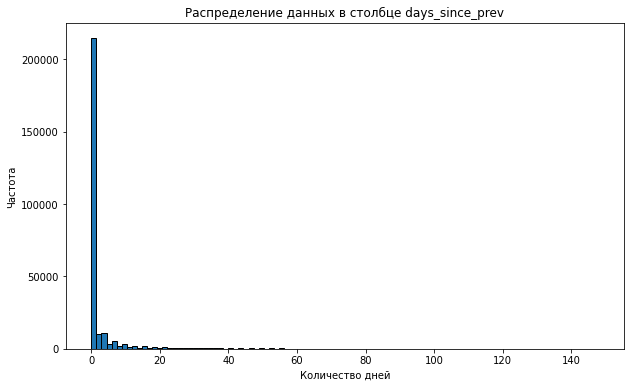

In [37]:
plt.figure(figsize=(10,6))

plt.hist(df[df['days_since_prev'].notna()]['days_since_prev'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце days_since_prev')
plt.xlabel('Количество дней')
plt.ylabel('Частота')

plt.show()

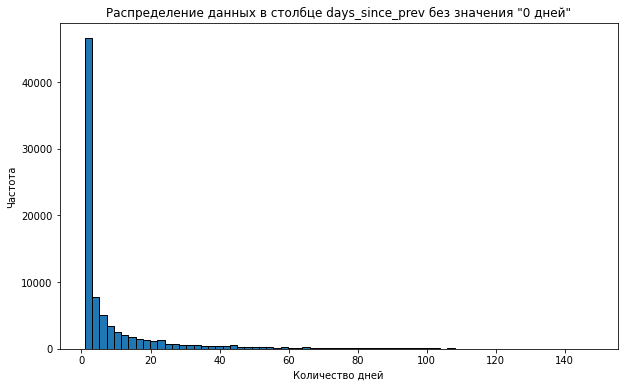

In [38]:
plt.figure(figsize=(10,6))

plt.hist(df[(df['days_since_prev'].notna())&(df['days_since_prev']>0)]['days_since_prev'],bins=70,edgecolor='black')

plt.title('Распределение данных в столбце days_since_prev без значения "0 дней"')
plt.xlabel('Количество дней')
plt.ylabel('Частота')

plt.show()

Из графиков выше видно, что распределение не нормальное, правоассиметричное, имеет длинный правый "хвост".

Уже начиная с 1 дня между заказами, частота резко снижается.

Диаграмма размаха:

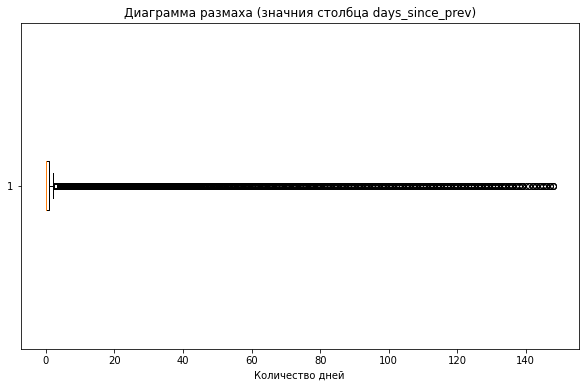

In [39]:
plt.figure(figsize=(10,6))

plt.boxplot(df[df['days_since_prev'].notna()]['days_since_prev'],vert=False)

plt.title('Диаграмма размаха (значния столбца days_since_prev)')
plt.xlabel('Количество дней')

plt.show()

Диаграмма размаха без отображения выбросов:

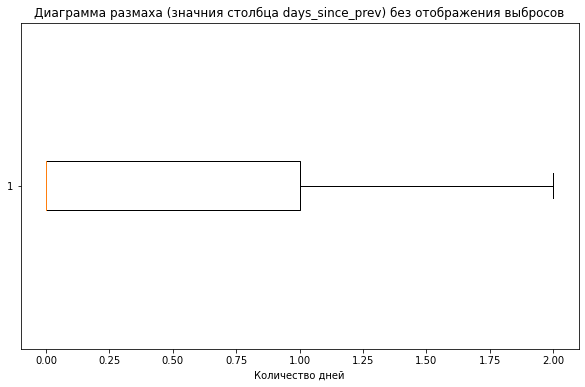

In [40]:
plt.figure(figsize=(10,6))

plt.boxplot(df[df['days_since_prev'].notna()]['days_since_prev'],vert=False,showfliers=False)

plt.title('Диаграмма размаха (значния столбца days_since_prev) без отображения выбросов')
plt.xlabel('Количество дней')

plt.show()

Диаграмма размаха не имеет правого "уса", поскольку первый квартиль совпадает со значением медианы. Значения более 2 дней исходя из критерия IQR между заказами считаются выбросами.

**Анализ значений столбца `tickets_count`:**

In [41]:
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

In [42]:
df['tickets_count'].mode()[0]

3

Значение среднего арифметического немного меньше, чем значение медианы - в среднем клиент за один заказ приобретает 3 билета. Значения моды и медианы равны.

Стандартное отклонение небольшое — большинство заказов близки к среднему.

Гистограмма распределения данных:

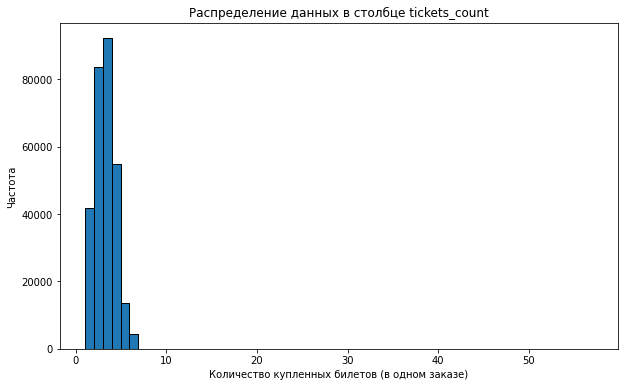

In [43]:
plt.figure(figsize=(10,6))

plt.hist(df['tickets_count'],bins=57,edgecolor='black')

plt.title('Распределение данных в столбце tickets_count')
plt.xlabel('Количество купленных билетов (в одном заказе)')
plt.ylabel('Частота')

plt.show()

Из графика выше следует, что распределение не нормальное, правоассиметричное, имеет правый "хвост". 
(хоть мода и медиана и больше среднего, что свидетельствует о левоассиметричном распределении, по графику видно, что это правоассиметричное распределение, имеющее длинный правый хвост)

Диаграмма размаха:

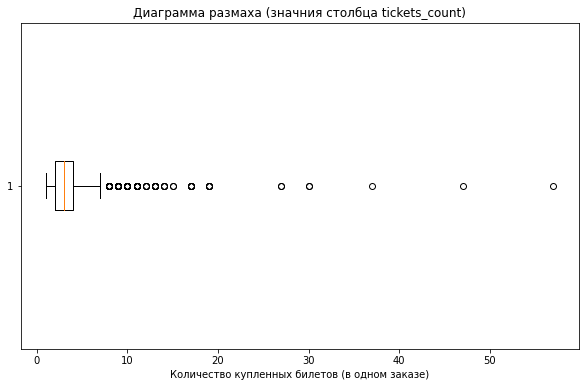

In [44]:
plt.figure(figsize=(10,6))

plt.boxplot(df['tickets_count'],vert=False)

plt.title('Диаграмма размаха (значния столбца tickets_count)')
plt.xlabel('Количество купленных билетов (в одном заказе)')

plt.show()

Диаграмма размаха без отображения выбросов:

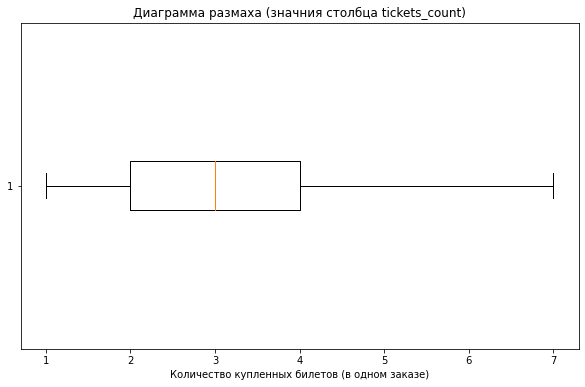

In [45]:
plt.figure(figsize=(10,6))

plt.boxplot(df['tickets_count'],vert=False,showfliers=False)

plt.title('Диаграмма размаха (значния столбца tickets_count)')
plt.xlabel('Количество купленных билетов (в одном заказе)')

plt.show()

Диаграмма размаха подтверждает, что распределение не является нормальным — оно скошено, с длинным хвостом вправо. 
Также на диаграмме хорошо визуализируются выбросы (значения более 7 билетов в одном заказе)

**Анализ значений столбца `revenue_rub`:**

In [46]:
df['revenue_rub'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    290611.000000
mean        555.568848
std         875.455505
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
95%        1630.650024
99%        2628.419922
max       81174.539062
Name: revenue_rub, dtype: float64

In [47]:
df['revenue_rub'].mode()[0]

0.0

Медиана меньше среднего арифметического значения, что свидетельствует от скошенности распределения. Имеются выбросы: максимальное значение в десятки раз больше, чем значение 99% процентиля.
Мода равна 0 (это может означать приобретение бесплатного билета, использование 100% скидки или подарочного сертификата, тестовый заказ). 

Минимальное значение отрицательное - вероятнее всего, это возвраты заказа (из описания проекта в Практикуме).

Количество и доля таких заказов с отрицательным значением в столбце `revenue_rub` (для таких заказов в базе данных значение столбца `total` (общая сумма заказа) из таблицы purchases схемы afisha также отрицательно):

In [48]:
ticket_refund = pd.Series({'Количество "возвратов"':df[df['revenue_rub']==0]['revenue_rub'].count(),
                                 'Доля "возвратов"':df[df['revenue_rub']==0]['revenue_rub'].count()/len(df),
                              'Процент "возвратов"':df[df['revenue_rub']==0]['revenue_rub'].count()/len(df) *100})
ticket_refund

Количество "возвратов"    5526.000000
Доля "возвратов"             0.019015
Процент "возвратов"          1.901511
dtype: float64

In [49]:
# Учитывая то, что по заданию выгрузку из базы данных необходимо было делать по определенным фильтрациям,
# и эти фильтрации не включали в себя условие revenue >= 0, то я не буду отфильтровывать/удалять такие
# строки из датасета. 

Гистограмма распределения данных:

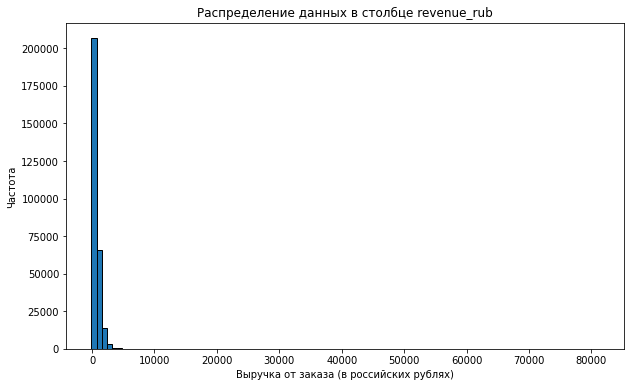

In [50]:
plt.figure(figsize=(10,6))

plt.hist(df['revenue_rub'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце revenue_rub')
plt.xlabel('Выручка от заказа (в российских рублях)')
plt.ylabel('Частота')

plt.show()

Из-за выбросов и большого максимального значения форма графика практически не видна. Следует только то, что распределение не нормальное, имеет длинный правый "хвост".

Гистограмма распределения данных, если данные отфильтровать и вывести значения ниже 99% процентиля.

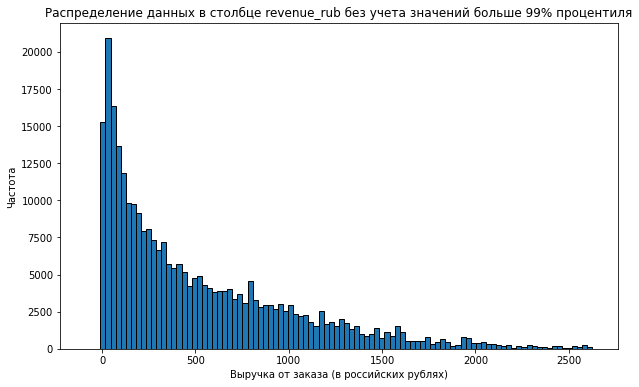

In [51]:
plt.figure(figsize=(10,6))

plt.hist(df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)]['revenue_rub'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце revenue_rub без учета значений больше 99% процентиля')
plt.xlabel('Выручка от заказа (в российских рублях)')
plt.ylabel('Частота')

plt.show()

Распределение скошено вправо, имеет длинный правый "хвост" (по мере роста значений выручки частота заказов постепенно падает)

Имеется пик вблизи нуля, что свидетельствует о большом количестве заказов с очень низкой выручкой.

Диаграмма размаха:

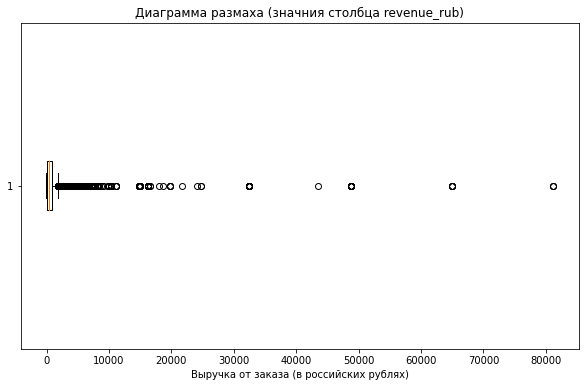

In [52]:
plt.figure(figsize=(10,6))

plt.boxplot(df['revenue_rub'],vert=False)

plt.title('Диаграмма размаха (значния столбца revenue_rub)')
plt.xlabel('Выручка от заказа (в российских рублях)')

plt.show()

Выбросы могут означать покупку большого количества билетов (например, корпоративная закупка, закупка билетов для школьников и т.п), либо покупку билетов в VIP-зоны, стоимость которых больше стоимости обычных билетов.

Диаграмма размаха без отображения выбросов:

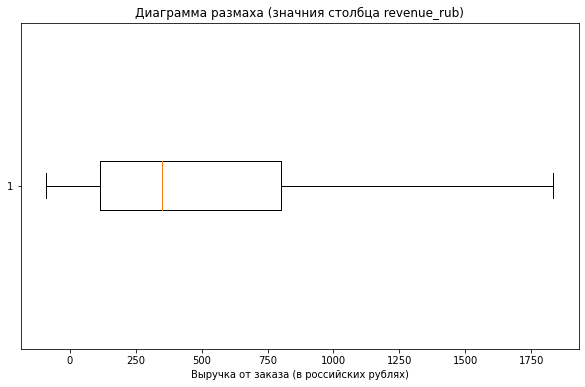

In [53]:
plt.figure(figsize=(10,6))

plt.boxplot(df['revenue_rub'],vert=False, showfliers=False)

plt.title('Диаграмма размаха (значния столбца revenue_rub)')
plt.xlabel('Выручка от заказа (в российских рублях)')

plt.show()

Диаграмма размаха подтверждает, что распределение не является нормальным — оно скошено вправо, правый "ус" длиннее левого.

На диаграмме видно, что отрицательные значения входят в "нормальный" диапазон (они не считаются выбросами по критериям IQR).


Отфильтруем для дальнейшей работы выбросы по значениям в поле `revenue_rub`. Оставлю все строки датасета, у которых значения в поле `revenue_rub` меньше 99% процентиля.

In [54]:
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

Размер датафрейма после фильтрации:

In [55]:
df.shape

(287786, 16)

In [56]:
print(f'Количество строк в датафрейме до фильтрации: {initial_len_df}')
print(f'Количество строк в датафрейме после фильтрации: {df.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_df - df.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_df - df.shape[0])/initial_len_df,
                         'Процент отфильтрованных строк': (initial_len_df - df.shape[0])/initial_len_df * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 290611
Количество строк в датафрейме после фильтрации: 287786


Отфильтровано строк:             2825.000000
Доля отфильтрованных строк:         0.009721
Процент отфильтрованных строк       0.972090
dtype: float64

### Промежуточный вывод:

**Задача 2.1** :  
На основе данных о курсе тенге к российскому рублю из датафрейма <u>df_tenge</u> в датафрейме <u>df</u> создан дополнительный столбец `revenue_rub`. Он содержит нормализованные данные, приведенные к значениям выручки только в российских рублях.  
- `revenue_rub` - выручка от заказа (в российских рублях)  
- Тип данных: float32  
- Пропущенные значения: нет

**Задача 2.2** :  

- Анализ дубликатов в поле с уникальными значениями `order_id`. Дубликаты не обнаружены.  

- Анализ пропусков

Тип пропусков в `days_since_prev` относятся к MAR. Пропуски появились при создании столбца `days_since_prev` при выгрузке из базы данных. Логика создания этого столбца предполагает наличие пропущенных значений: Nan указывает на то, что клиент покупал билеты только единожды.  
Из этого можно заключить, что всего 7,5% клиентов совершали только одну покупку, а оставшиеся 92,5% заказов совершались клиентами, у которых более одной покупки.  
Последующая обработка пропусков не проводилась, поскольку созданный столбец предполагает наличие значений Nan.

- Типы данных:

Изменен тип данных (float64 -> Int16) в столбце `days_since_prev`.  
Понижена размерность в столбцах: `tickets_count`, `event_id`, `order_id` (целочисленный тип данных); `revenue`, `revenue_rub` (вещественный тип данных)

- В ходе анализа уникальных значений столбцов с номинальными данными ошибок не выявлено. Нормализация данных не проводилась.

Данные представлены для заказов, сделанных с мобильных устройств и стационарных устройств.  
Заказы были оплачены двумя видами валют: тенге, российский рубль.  
Билеты приобретались на различные типы мероприятий: выставки, концерты, спорт, стендап, театр, ёлки, другое.  
Заказы совершались из большого числа различных регионов и городов.


- В ходе анализа ключевых столбцов с числовыми значениями было выявлено: 

Распределение значений во всех трех столбцах не нормальные, правоассиметричные, с правыми "хвостами". 

1. столбец `days_since_prev`  
В среднем между заказами проходит около 3 дней, но значение среднего арифметического (3.2 дня) и медианы значительно отличаются. Также и значение 75% процентиля (1 день) отлично от значения среднего (3.2 дня), что свидетельствует от наличии больших значений, "тянущих" среднее арифметическое в сторону больших значений - это клиенты, которые возвращаются через большое количество дней и совершают повторные покупки билетов. Также эти клиенты влияют на стандартное отклонение: оно очень большое по сравнению со средним арифметическим - есть длинный "хвост".  
Максимальное количество дней между заказами: 148 дней, минимальное - 0 дней.  
Значения более 2 дней исходя из критерия IQR между заказами считаются выбросами.


2. столбец `tickets_count`  
Значение среднего арифметического немного меньше (2.75 шт.), чем значение медианы (3 шт.) - в среднем клиент за один заказ приобретает 3 билета. Значения моды и медианы равны. Стандартное отклонение небольшое, что свидетельствует о том, что большинство заказов близки к среднему.  
Максимальное количество билетов в заказе: 57, минимальное - 1.  
Значения более 7 билетов в одном заказе исходя из критерия IQR считаются выбросами. Выбросы могут означать покупку большого количества билетов в виду корпоративной закупки, закупки билетов для школьников/студентов и т.п.


3. столбец `revenue_rub`  
Медиана (351 руб.) меньше среднего арифметического значения (555 руб.). Имеются выбросы: максимальное значение (81 174 руб.) в десятки раз больше, чем значение 99% процентиля (2 628 руб.) . Мода равна 0 (это может означать приобретение бесплатного билета, использование 100% скидки или подарочного сертификата, тестовый заказ).
Минимальное значение отрицательное (- 90 руб.) - вероятнее всего, это возвраты заказа (из описания проекта в Практикуме).  
Выбросы могут означать покупку большого количества билетов (например, корпоративная закупка, закупка билетов для школьников и т.п), либо покупку билетов в VIP-зоны, стоимость которых больше стоимости обычных билетов.

Были отфильтрованы данные по 99% процентилю. В итоге отфильтровано (удалено из анализа) 2825 строк, что составляет около 1% от всех данных.

Датафрейм <u>df</u> после фильтрации содержит 287 786 строк.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Сортирую датафрейм по времени совершения заказа:

In [57]:
df = df.sort_values(by=['user_id','order_ts'])

Проверка результата сортировки:

In [58]:
df[['user_id', 'order_ts']]

,user_id,order_ts
0,0002849b70a3ce2,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-07-23 18:36:24
2,0005ca5e93f2cf4,2024-10-06 13:56:02
3,000898990054619,2024-07-13 19:40:48
4,000898990054619,2024-10-04 22:33:15
...,...,...
290607,fffcd3dde79eb2c,2024-10-27 17:54:52
290605,fffcd3dde79eb2c,2024-10-27 18:00:57
290608,fffcd3dde79eb2c,2024-10-30 13:37:43
290609,fffeeb3c120cf0b,2024-09-24 10:07:42


In [59]:
# Создаю сводную таблицу по каждому пользователю (поле user_id), чтобы построить профиль пользователя:

# При создании сводной таблицы нарушался порядок выведения столбцов, они были перемешаны и 
# новые названия столбцов не присваивались верно (по порядку)

# В связи с этим я создала далее сводную таблицу через groupby() 

# Как корректнее поступать при таких заданиях? Создавать сводную таблицу с мультииндексами и потом 
# вручную переделывать порядок отображения столбцов? 
# Или здесь корректнее использовать сразу groupby?

In [60]:
# user_profile = pd.pivot_table( df, index='user_id', aggfunc={'order_dt': [min, max],
#                                                             'device_type_canonical': 'first', 
#                                                             'region_name': 'first', 
#                                                             'service_name': 'first',
#                                                             'event_type_main': 'first',
#                                                             'order_id': 'count', 
#                                                             'revenue_rub': 'mean', 
#                                                             'tickets_count': 'mean', 
#                                                             'days_since_prev': 'mean'} ) 

# Переименовываю названия столбцов
#user_profile.columns = [ 'first_order', 'last_order', 'device_type_f', 
                   #     'region_f', 'service_name_f', 'event_type_f', 
                    #    'total_orders', 'avg_revenue', 'avg_tickets', 'avg_time' ]


In [61]:
user_profile = df.groupby('user_id').agg(first_order=('order_dt', 'min'),
                                                last_order=('order_dt', 'max'), 
                                                device_type_f=('device_type_canonical', 'first'), 
                                                region_f=('region_name', 'first'),
                                                service_name_f=('service_name', 'first'), 
                                                event_type_f=('event_type_main', 'first'), 
                                                total_orders=('order_id', 'count'), 
                                                avg_revenue=('revenue_rub', 'mean'), 
                                                avg_tickets=('tickets_count', 'mean'),
                                                avg_time=('days_since_prev', 'mean'))

# Проверяю результат
user_profile.head(3)

,first_order,last_order,device_type_f,region_f,service_name_f,event_type_f,total_orders,avg_revenue,avg_tickets,avg_time
user_id,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,<NA>
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0


Добавляю два дополнительных поля: `is_two` — совершил ли пользователь 2 и более заказа; `is_five` — совершил ли пользователь 5 и более заказов.

In [62]:
# Функция, для создания бинарного признака is_two
def create_is_two(x):
    if x >= 2:
        return 1
    else:
        return 0

# Функция, для создания бинарного признака is_five    
def create_is_five(x):
    if x >= 5:
        return 1
    else:
        return 0

# Применяем функции к столбцу total_orders
user_profile['is_two'] = user_profile['total_orders'].apply(create_is_two)
user_profile['is_five'] = user_profile['total_orders'].apply(create_is_five)

# Проверяю результат
user_profile.head()

,first_order,last_order,device_type_f,region_f,service_name_f,event_type_f,total_orders,avg_revenue,avg_tickets,avg_time,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,<NA>,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,<NA>,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


При группировке user_id  стал индексом, поэтому использую метод reset_index и сделаю `user_id` обыкновенным столбцом:

In [63]:
user_profile = user_profile.reset_index()

# Проверяю результат
user_profile.columns

Index(['user_id', 'first_order', 'last_order', 'device_type_f', 'region_f',
       'service_name_f', 'event_type_f', 'total_orders', 'avg_revenue',
       'avg_tickets', 'avg_time', 'is_two', 'is_five'],
      dtype='object')

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [64]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         21854 non-null  object        
 1   first_order     21854 non-null  datetime64[ns]
 2   last_order      21854 non-null  datetime64[ns]
 3   device_type_f   21854 non-null  object        
 4   region_f        21854 non-null  object        
 5   service_name_f  21854 non-null  object        
 6   event_type_f    21854 non-null  object        
 7   total_orders    21854 non-null  int64         
 8   avg_revenue     21854 non-null  float32       
 9   avg_tickets     21854 non-null  float64       
 10  avg_time        13513 non-null  Float64       
 11  is_two          21854 non-null  int64         
 12  is_five         21854 non-null  int64         
dtypes: Float64(1), datetime64[ns](2), float32(1), float64(1), int64(3), object(5)
memory usage: 2.1+ MB


Информация о пропусках:

In [65]:
missing_stats_user = pd.Series({'Кол-во пропусков': user_profile['avg_time'].isna().sum(),
                              'Доля пропусков': user_profile['avg_time'].isna().mean(),
                           'Процент пропусков': user_profile['avg_time'].isna().mean() * 100})

missing_stats_user

Кол-во пропусков     8341.000000
Доля пропусков          0.381669
Процент пропусков      38.166926
dtype: float64

Размер датафрейма с информацией о профиле пользователей содержит 21 848 строк и 13 столбцов.

Пропуски имеются только в столбце `avg_time` - около 40% от представленных данных. Пропуски в этом столбце означают то же самое, что и пропуски в столбце `days_since_prev`, на основе которого был сделан столбец `avg_time` - NA означает то, что клиент совершал только 1 заказ и дней между заказами у него вообще нет.

Объем используемой памяти 2.1+ MB. 

______

Количество уникальных пользователей будет равняться количеству строк датафрейма <u>user_profile</u>, поскольку для создания этого датафрейма использовалась группировка по столбцу `user_id`, то все значения этого поля уникальны.

Среднюю выручку с одного заказа можно рассчитать по формуле: 

    суммарная выручка от всех клиентов/ количество клиентов 
    
и сравнить получившееся значение с применением метода mean() (среднее от среднего, поскольку столбец `avg_revenue` хранит средние значения выручки за заказ)

In [66]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]} пользователей')
print(f'Средняя выручка с одного заказа (рассчитаное по формуле): {round(user_profile["avg_revenue"].sum()/user_profile.shape[0],2)} руб.')
print(f'Средняя выручка с одного заказа (среднее от среднего): {round(user_profile["avg_revenue"].mean(),2)} руб.')
print(f'Кол-во клиентов, совершивших 2 и более заказа: {user_profile["is_two"].sum()} пользователей. Доля: {round(user_profile["is_two"].mean(),2)}')
print(f'Кол-во клиентов, совершивших 5 и более заказов: {user_profile["is_five"].sum()} пользователей. Доля: {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке: 21854 пользователей
Средняя выручка с одного заказа (рассчитаное по формуле): 544.4 руб.
Средняя выручка с одного заказа (среднее от среднего): 544.4 руб.
Кол-во клиентов, совершивших 2 и более заказа: 13486 пользователей. Доля: 0.62
Кол-во клиентов, совершивших 5 и более заказов: 6339 пользователей. Доля: 0.29


**Анализ значений в столбце `total_orders`:**

In [67]:
user_profile['total_orders'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
95%         31.350000
99%        152.000000
max      10181.000000
Name: total_orders, dtype: float64

In [68]:
user_profile['total_orders'].mode()[0]

1

Среднее арифметическое сильно отличаеся от значения медианы, стандартное отклонение велико - это свидетельствует о наличии аномально больших значений (максимальное значение в 66 раз больше, чем значение 99% процентиля и в 328 раз больше, чем значение 95% процентиля). Мода меньше медианы и ее значение равняется минимальному значению, а также 25 % процентилю.
Распределение не нормальное, правоассиметричное, с длинным правым "хвостом".

Гистограмма распределения данных:

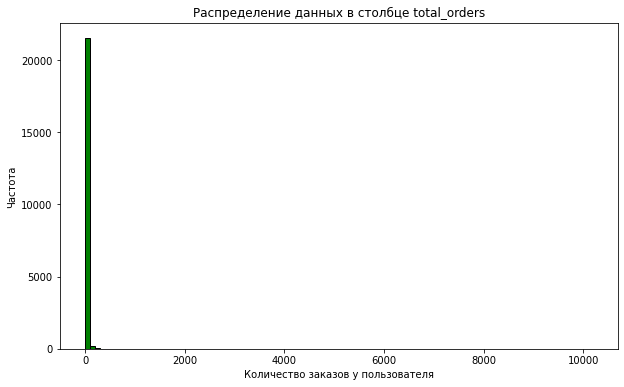

In [69]:
plt.figure(figsize=(10,6))

plt.hist(user_profile['total_orders'],bins=100,edgecolor='black',color='green')

plt.title('Распределение данных в столбце total_orders')
plt.xlabel('Количество заказов у пользователя')
plt.ylabel('Частота')

plt.show()

Гистограмма распределения данных с отфильтрованными значениями (отображение значений меньше 95% процентиля):

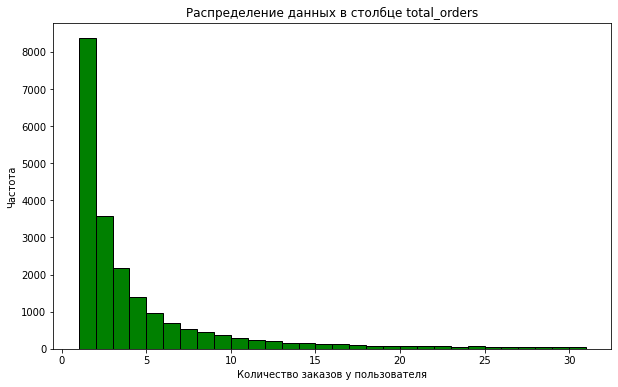

In [70]:
plt.figure(figsize=(10,6))

plt.hist(user_profile[user_profile['total_orders']<user_profile['total_orders'].quantile(0.95)]['total_orders'],bins=30,edgecolor='black',color='green')

plt.title('Распределение данных в столбце total_orders')
plt.xlabel('Количество заказов у пользователя')
plt.ylabel('Частота')

plt.show()

На графике сильно выделяются значения около 1, далее количество заказов у пользователей резко убывает.

Диаграмма размаха:

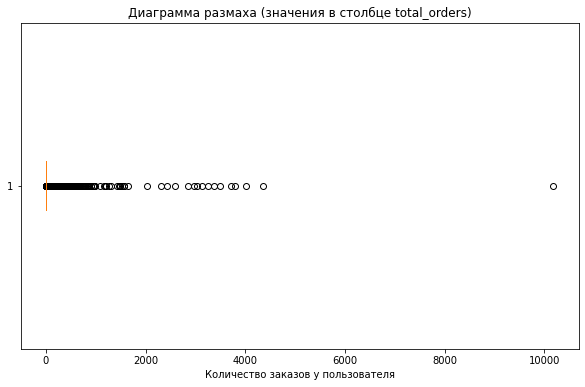

In [71]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['total_orders'], vert=False)

plt.title('Диаграмма размаха (значения в столбце total_orders)')
plt.xlabel('Количество заказов у пользователя')

plt.show()

Видно большое количество выбросов в широком диапазоне. "Ящик с усами" не визуализируется, если на графике отображены выбросы.

Диаграмма размаха без отображения выбросов:

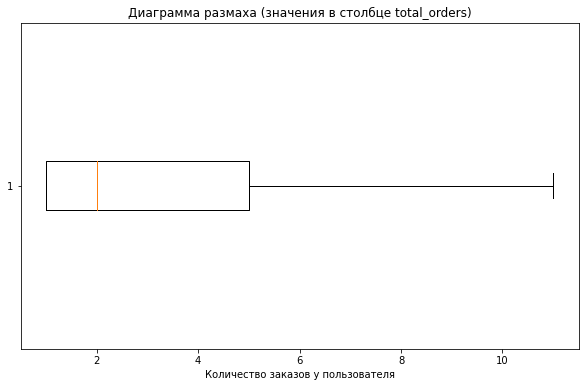

In [72]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['total_orders'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце total_orders)')
plt.xlabel('Количество заказов у пользователя')

plt.show()

"Ящик" не имеет "левого" уса, поскольку минимальное значение совпадает со значением Q1(25% процентиль). Линия медианы смещена, на графике имеется только правый "ус", что подтверждает ассиметричность распределения и его скошенность.

Необходимо провести дальнейшую фильтрацию, но необходимо оценить количество данных, в которых значения в столбце total_orders больше 95% и 99% процентилей:

In [73]:
print(f'Количество строк со значениями > 95% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.95)].shape[0]}')
print(f'Доля строк со значениями > 95% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.95)].shape[0]/user_profile.shape[0]}')
print()
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 95% процентиля: 1093
Доля строк со значениями > 95% процентиля: 0.0500137274640798

Количество строк со значениями > 99% процентиля: 220
Доля строк со значениями > 99% процентиля: 0.010066806991855038


Значение 95% процентиля отражает количество заказов у одного пользователя - около 31: столько заказов за период с июня по октябрь (5 месяцев) — это примерно 6 заказов в месяц. Для обычного активного пользователя это вполне реально, поэтому фильтрацию буду проводить по 95% процентилю.

**Анализ значений в столбце `avg_tickets`:**

In [74]:
user_profile['avg_tickets'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

In [75]:
user_profile['avg_tickets'].mode()[0]

3.0

Можно утверждать о том, что среднее арифметическое и медиана равны (различие в 0.01), что может свидетельствовать о симметричном распределении. Но при этом мода чуть больше, чем медиана.
Максимальное значение в 2 раза больше, чем значение 99% процентиля, что свидетельствует о наличии аномальных значений и появлении на графике правого "хвоста".

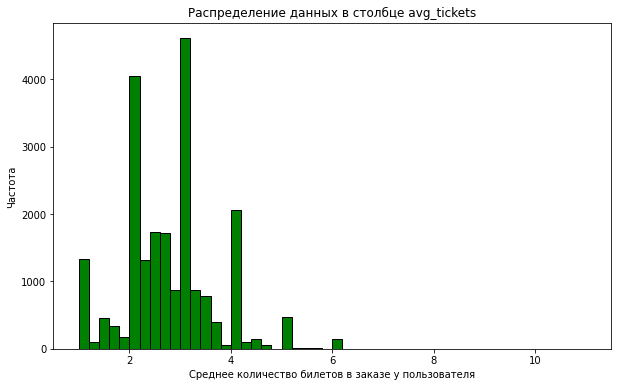

In [76]:
plt.figure(figsize=(10,6))

plt.hist(user_profile['avg_tickets'],bins=50,edgecolor='black',color='green')

plt.title('Распределение данных в столбце avg_tickets')
plt.xlabel('Среднее количество билетов в заказе у пользователя')
plt.ylabel('Частота')

plt.show()

Пики наблюдаются около значения 2 и около значения 3, что означает, что наиболее типичное поведение пользователя — покупать от 2 до 3 билетов за заказ.

Форма распределения — скошенная вправо. Большинство пользователей имеют значения в диапазоне 1–4 билета, а дальше представлены редкие случаи.

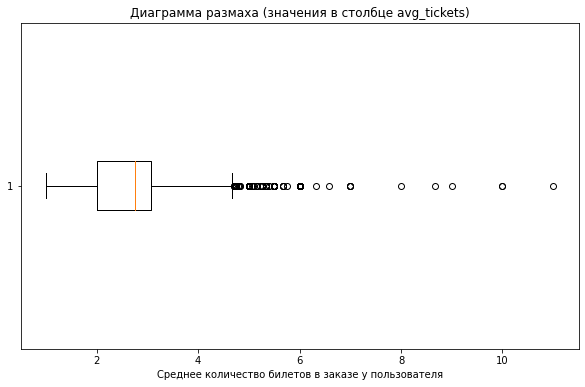

In [77]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['avg_tickets'], vert=False)

plt.title('Диаграмма размаха (значения в столбце avg_tickets)')
plt.xlabel('Среднее количество билетов в заказе у пользователя')

plt.show()

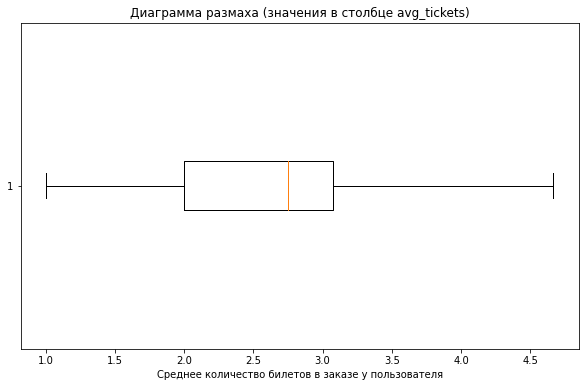

In [78]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['avg_tickets'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце avg_tickets)')
plt.xlabel('Среднее количество билетов в заказе у пользователя')

plt.show()

Левый "ус" короче правого, что подтверждает ассиметричность распределения и наличие правого "хвоста", состоящего из выбросов.

Оценка количества данных, в которых значения в столбце avg_tickets больше 95% и 99% процентилей:

In [79]:
print(f'Количество строк со значениями > 95% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.95)].shape[0]}')
print(f'Доля строк со значениями > 95% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.95)].shape[0]/user_profile.shape[0]}')
print()
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 95% процентиля: 3011
Доля строк со значениями > 95% процентиля: 0.137777981147616

Количество строк со значениями > 99% процентиля: 661
Доля строк со значениями > 99% процентиля: 0.030246179189164456


**Анализ значений в столбце `avg_time`:**

In [80]:
user_profile['avg_time'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    13513.000000
mean        15.851275
std         22.306224
min          0.000000
25%          1.000000
50%          8.000000
75%         20.428571
95%         61.500000
99%        112.000000
max        148.000000
Name: avg_time, dtype: float64

In [81]:
user_profile['avg_time'].mode()[0]

0.0

Значения среднего арифметического и медианы сильно отличаются, значение стандартного отклонения велико (больше среднего арифметического). Мода совпадает с минимальным значением (0 дней между заказами).  
Минимальное значение - 0 дней между заказами, максимальное - 148 дней между заказами. Имеются большие значения, которые создают правый "хвост".

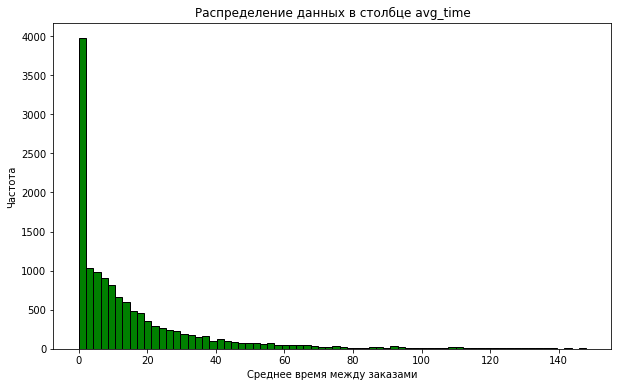

In [82]:
plt.figure(figsize=(10,6))

plt.hist(user_profile[user_profile['avg_time'].notna()]['avg_time'],bins=70,edgecolor='black',color='green')

plt.title('Распределение данных в столбце avg_time')
plt.xlabel('Среднее время между заказами')
plt.ylabel('Частота')

plt.show()

Распределение не нормальное, скошенное вправо, имеет "хвост". Также на графике визуализируется пик около значения 0, отчетливо визуализирующий значение моды и то, сколько раз такое значение встречается.

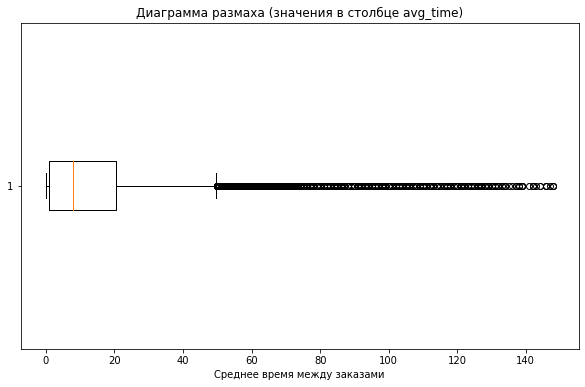

In [83]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile[user_profile['avg_time'].notna()]['avg_time'], vert=False)

plt.title('Диаграмма размаха (значения в столбце avg_time)')
plt.xlabel('Среднее время между заказами')

plt.show()

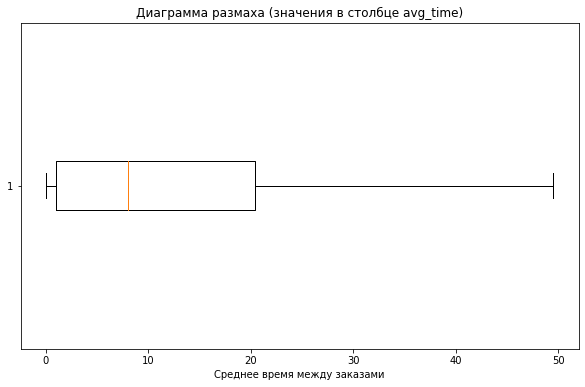

In [84]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile[user_profile['avg_time'].notna()]['avg_time'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце avg_time)')
plt.xlabel('Среднее время между заказами')

plt.show()

Распределение асимметричное, скошенное вправо. Это также видно на диаграмме размаха, где левый "ус" намного короче "правого". Значение медианы также сдвинуто, оно находится не в середине "ящика". 

_____

Фильтрация данных (по значению 95% процентиля столбца total_orders):

In [85]:
# Длина датафрейма до фильтрации
initial_len_user_profile = user_profile.shape[0]

user_profile = user_profile[user_profile["total_orders"] <= user_profile["total_orders"].quantile(0.95)]

In [86]:
print(f'Количество строк в датафрейме до фильтрации: {initial_len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile,
                         'Процент отфильтрованных строк': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 21854
Количество строк в датафрейме после фильтрации: 20761


Отфильтровано строк:             1093.000000
Доля отфильтрованных строк:         0.050014
Процент отфильтрованных строк       5.001373
dtype: float64

После фильтрации проверка распределения значений в столбце avg_tickets:

In [87]:
user_profile['avg_tickets'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    20761.000000
mean         2.743605
std          0.934540
min          1.000000
25%          2.000000
50%          2.750000
75%          3.150000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

Максимальное значение среднего количества билетов в заказе - 11 билетов - свидетельствует о сегменте пользователей, которые совершали корпоративные и прочие закупки, которые характеризуются покупкой билетов на большое количество человек.  
После фильтрациии датафрейма с профилями пользователей по общему количеству заказов такие "корпоративные" клиенты остались, поэтому далее необходимо провести фильтрацию по значению 99% процентиля столбца avg_tickets:

Предварительно оцениваю количество строк, которые могут быть отфильтрованы:

In [88]:
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 99% процентиля: 661
Доля строк со значениями > 99% процентиля: 0.031838543422763835


Провожу фильтрацию по значению 99% процентиля столбца avg_tickets:

In [89]:
# Промежуточный размер датафрейма (после первой фильтрации, до второй фильтрации)
len_user_profile = user_profile.shape[0]

user_profile = user_profile[user_profile['avg_tickets'] <= user_profile['avg_tickets'].quantile(0.99)]

In [90]:
print(f'Количество строк в датафрейме до фильтрации: {len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (len_user_profile - user_profile.shape[0])/len_user_profile,
                         'Процент отфильтрованных строк': (len_user_profile - user_profile.shape[0])/len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 20761
Количество строк в датафрейме после фильтрации: 20567


Отфильтровано строк:             194.000000
Доля отфильтрованных строк:        0.009344
Процент отфильтрованных строк      0.934444
dtype: float64

Итого после фильтрации по двум полям:

In [91]:
print(f'Количество строк в датафрейме до фильтрации: {initial_len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile,
                         'Процент отфильтрованных строк': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 21854
Количество строк в датафрейме после фильтрации: 20567


Отфильтровано строк:             1287.000000
Доля отфильтрованных строк:         0.058891
Процент отфильтрованных строк       5.889082
dtype: float64

После фильтрации информация по следующим показателям обновлена:

In [92]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]} пользователей')
print(f'Средняя выручка с одного заказа (рассчитаное по формуле): {round(user_profile["avg_revenue"].sum()/user_profile.shape[0],2)} руб.')
print(f'Средняя выручка с одного заказа (среднее от среднего): {round(user_profile["avg_revenue"].mean(),2)} руб.')
print(f'Кол-во клиентов, совершивших 2 и более заказа: {user_profile["is_two"].sum()} пользователей. Доля: {round(user_profile["is_two"].mean(),2)}')
print(f'Кол-во клиентов, совершивших 5 и более заказов: {user_profile["is_five"].sum()} пользователей. Доля: {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке: 20567 пользователей
Средняя выручка с одного заказа (рассчитаное по формуле): 544.26 руб.
Средняя выручка с одного заказа (среднее от среднего): 544.26 руб.
Кол-во клиентов, совершивших 2 и более заказа: 12330 пользователей. Доля: 0.6
Кол-во клиентов, совершивших 5 и более заказов: 5236 пользователей. Доля: 0.25


Статистики после фильтрации: 

In [93]:
for col in ['total_orders','avg_tickets','avg_time']:
    print(user_profile[col].describe())

count    20567.000000
mean         4.070890
std          5.129655
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: total_orders, dtype: float64
count    20567.000000
mean         2.712880
std          0.880810
min          1.000000
25%          2.000000
50%          2.750000
75%          3.090909
max          5.000000
Name: avg_tickets, dtype: float64
count    12356.000000
mean        17.109693
std         22.887984
min          0.000000
25%          1.000000
50%          9.500000
75%         22.250000
max        148.000000
Name: avg_time, dtype: float64


Вид гистограмм распределения после фильтрации:

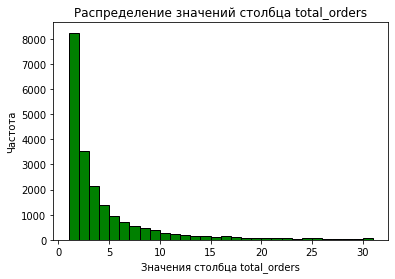

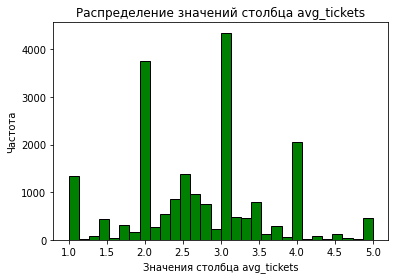

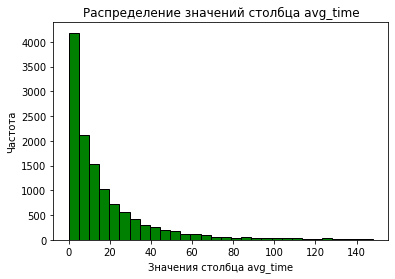

In [94]:
for col in ['total_orders','avg_tickets','avg_time']:
    plt.hist(user_profile[user_profile[col].notna()][col],bins=30,edgecolor='black',color='green')
    plt.title(f'Распределение значений столбца {col}')
    plt.xlabel(f'Значения столбца {col}')
    plt.ylabel('Частота')
    plt.show()

Вид диаграмм разброса после фильтрации:

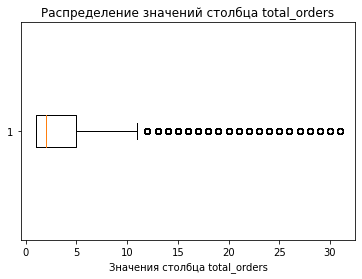

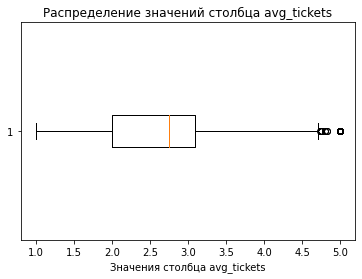

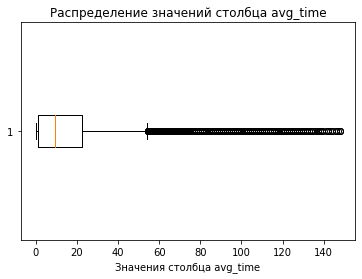

In [95]:
for col in ['total_orders','avg_tickets','avg_time']:
    plt.boxplot(user_profile[user_profile[col].notna()][col],vert=False)
    plt.title(f'Распределение значений столбца {col}')
    plt.xlabel(f'Значения столбца {col}')
    plt.show()

После фильтрации значения в столбце `total_orders` распределены следующим образом: среднее арифметическое в два раза больше значения медианы, стандартное отклонение велико и его значение больше среднего арифметического. Распределение не нормальное. Минимальное значение осталось таким же, максимальное "сдвинулось влево" и теперь равно 31 заказу у пользователя.  
Значения в столбце `avg_tickets` распределены: среднее арифметическое и медиана имеют теперь немного большее различие, чем до фильтрации, но эти различия всё ещё заключаются в нескольких сотых значения. Максимальное значение теперь также "сдвинуто влево" и равно 5 билетам в одном заказе. Гистограмма распределения стала визуально более симметричной, если исключить пики около некоторых значений из визуального анализа.
Значения в столбце `avg_time` также изменились: значение среднего и медианы "выросли" приблизительно на 1.5, максимальное количество дней между заказами осталось прежним.

### Промежуточный вывод:

**Задача 3.1: Создание профиля пользователя** 

На основе информации в датафрейме <u>df</u> построена сводная таблица с агрегированными данными (профиль пользователя) <u>user_profile</u> .  
Описание столбцов:   
`user_id` - id пользователя;  
`first_order` - дата первого заказа;   
`last_order` - дата последнего заказа;  
`device_type_f` - устройство, с которого был сделан первый заказ;  
`region_f` - регион мероприятия, в котором был сделан первый заказ;  
`service_name_f` - билетный партнёр, к которому обращались при первом заказе;  
`event_type_f` - жанр первого посещённого мероприятия;  
`total_orders` - общее количество заказов;  
`avg_revenue` - средняя выручка с одного заказа (в рублях);  
`avg_tickets` - среднее количество билетов в заказе;  
`avg_time` - среднее время между заказами.  
  
А также два дополнительных поля:  
`is_two` - совершил ли пользователь 2 и более заказа;  
`is_five` - совершил ли пользователь 5 и более заказов.  

Размер датафрейма с информацией о профиле пользователей содержит 21 854 строк и 13 столбцов.  
Пропуски имеются только в столбце `avg_time` - около 40% от представленных данных. Пропуски в этом столбце означают то, что клиент совершал только 1 заказ и дней между заказами у него вообще нет.  
Объем используемой памяти 2.1+ MB. 

**Задача 3.2: Анализ данных в профиле пользователя** 

Общее число пользователей в выборке - 21 854 пользователя, средняя выручка с одного заказа - 544 руб., процент пользователей, совершивших 2 и более заказа - 62% , процент пользователей, совершивших 5 и более заказов - 29% .

Изучены статистические показатели:

- `total_orders`  
Среднее арифметическое (13.16) сильно отличаеся от значения медианы (2), стандартное отклонение велико (121.67)- это свидетельствует о наличии аномально больших значений (максимальное значение в 66 раз больше, чем значение 99% процентиля и в 328 раз больше, чем значение 95% процентиля). Мода (1) меньше медианы (2) и ее значение равняется минимальному значению, а также 25 % процентилю. Распределение не нормальное, правоассиметричное, с длинным правым "хвостом".  
Значение 95% процентиля отражает количество заказов у одного пользователя - около 31: столько заказов за период с июня по октябрь (5 месяцев) — это примерно 6 заказов в месяц. Для обычного активного пользователя это вполне реально, поэтому дальнейшая фильтрация будет проводиться по 95% процентилю.

- `avg_tickets`  
Среднее арифметическое (2.74) и медиана (2.75) равны, что может свидетельствовать о симметричном распределении. Но при этом мода (3) чуть больше, чем медиана. Максимальное значение в 2 раза больше, чем значение 99% процентиля, что свидетельствует о наличии аномальных значений и появлении на графике правого "хвоста".
Максимальное значение среднего количества билетов в заказе - 11 билетов - свидетельствует о сегменте пользователей, которые совершали корпоративные и прочие закупки, которые характеризуются покупкой билетов на большое количество человек. Будет проводиться дальнейшая фильтрация по значению 99% процентиля этого столбца.

- `avg_time`  
Значения среднего арифметического (15.85) и медианы (8) сильно отличаются, значение стандартного отклонения велико (22.3, больше среднего арифметического). Мода совпадает с минимальным значением (0 дней между заказами).  
Минимальное значение - 0 дней между заказами, максимальное - 148 дней между заказами. Имеются большие значения, которые создают правый "хвост". Распределение не нормальное, правоассиметричное, с правым "хвостом".  

Проведена фильтрация по 95% процентилю значений столбца `total_orders` и последующая фильтрация по 99% процентилю значений столбца `avg_tickets`.
В ходе фильтрации отфильтровано (удалено из анализа) 1287 строк, что составляет менее 6% данных. 

После фильтрации: общее число пользователей в выборке - 20 567 пользователей (*-1287 пользователя*), средняя выручка с одного заказа - 544 руб.(*-0 руб.*), процент пользователей, совершивших 2 и более заказа - 60% (*-2%*) , процент пользователей, совершивших 5 и более заказов - 25% (*-4%*) .

Статистические показатели после фильтрации по обновлённому датасету:

- `total_orders`  
Среднее арифметическое (4) в два раза больше значения медианы (2), стандартное отклонение велико (5.12) и его значение больше среднего арифметического. Но эти различия стали меньше по сравнению с тем, что было до фильтрации. Распределение не нормальное. Минимальное значение осталось таким же, максимальное "сдвинулось влево" (31)

- `avg_tickets`  
Среднее арифметическое (2.71) и медиана (2.75) имеют теперь немного большее различие, чем до фильтрации, но эти различия всё ещё заключаются в нескольких сотых значения. Максимальное значение (5) теперь также "сдвинуто влево". Гистограмма распределения стала визуально более симметричной, если исключить пики около некоторых значений из визуального анализа.

- `avg_time`  
Значение среднего (17.1) и медианы (9.5) "выросли" приблизительно на 1.5, максимальное количество дней между заказами осталось прежним.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Задаю функцию, которая будет выводить информацию о сегментах пользователей:

In [96]:
# Функция, выводящая информацию о заданном сегменте пользователей
def segmentation(series):
    print (pd.DataFrame({'Количество пользователей:':series.value_counts(),
                             'Доля пользователей:':series.value_counts(normalize=True)}))

Сегментация пользователей (**по типу их первого мероприятия**):

In [97]:
segmentation(user_profile['event_type_f'])

          Количество пользователей:  Доля пользователей:
концерты                       9142             0.444498
другое                         5094             0.247678
театр                          4033             0.196091
стендап                        1055             0.051296
спорт                           750             0.036466
выставки                        399             0.019400
ёлки                             94             0.004570


Концерты — главная "точка входа". Почти половина пользователей (44%) впервые пришли через концерт. Категория "другое" нуждается в расшифровке (это могут быть лекции, фестивали, что-то ещё). Почти 20 % пользователей — это театральные зрители.  
Ёлки - сезонный сегмент, поэтому в нем так мало пользователей. Ведь данные представлены за летние месяцы и два первых осенних месяца. Возможно, этот сегмент здесь появился потому, что пользователи заранее в октябре приобрели билеты.

Сегментация пользователей (**по типу устройства, с которого совершена первая покупка**):

In [98]:
segmentation(user_profile['device_type_f'])

         Количество пользователей:  Доля пользователей:
mobile                       17067             0.829824
desktop                       3500             0.170176


В сегменте по типу устройства, с которого совершена первая покупка, количество пользователей и их доля распределены не равномерно: около 83% пользователей сделали свой заказ с мобильного телефона (это выраженная "точка входа"). Оставшиеся 17% пользователей сделали свой первый заказ со стационарного устройства.

Сегментация пользователей (**по региону проведения мероприятия из первого заказа**):

In [99]:
segmentation(user_profile['region_f'])

                          Количество пользователей:  Доля пользователей:
Каменевский регион                             6726             0.327029
Североярская область                           3546             0.172412
Широковская область                            1170             0.056887
Озернинский край                                656             0.031896
Малиновоярский округ                            511             0.024846
...                                             ...                  ...
Тихогорская область                               2             0.000097
Светолесский край                                 1             0.000049
Верхозёрский край                                 1             0.000049
Сосноводолинская область                          1             0.000049
Яснопольский округ                                1             0.000049

[81 rows x 2 columns]


Сегменты пользователей по регионам распределены также неравномерно: в Каменевском регионе на первое мероприятие приобрели билеты треть всех пользователей (32%), 17% пользователей приходится на Североярскую область. Оставшийся 51% неравномерно распределен по 79 регионам (Широковская область - 5% пользователей, Озернинский край - 3% пользователей, и так далее до тысячных долей процента). 

Сегментация пользователей (**по билетному оператору, продавшему билеты на первый заказ**):

In [100]:
segmentation(user_profile['service_name_f'])

                        Количество пользователей:  Доля пользователей:
Билеты без проблем                           4899             0.238197
Мой билет                                    2830             0.137599
Лови билет!                                  2685             0.130549
Билеты в руки                                2405             0.116935
Облачко                                      2097             0.101959
Весь в билетах                               1222             0.059416
Лучшие билеты                                1121             0.054505
Прачечная                                     546             0.026547
Край билетов                                  436             0.021199
Дом культуры                                  337             0.016385
Яблоко                                        306             0.014878
Тебе билет!                                   295             0.014343
Городской дом культуры                        207             0.010065
Мир ка

Данные в этом сегменте распределены также неравномерно: выделяется билетный оператор "Билеты без проблем", продавший билеты на первый заказ около 24% пользователям. Далее за ним следуют операторы "Мой билет", "Лови билет",  "Билеты в руки", "Облачко" - от 10% до 14% пользователям они продали билеты на первый заказ. Далее для остальных сервисов проценты пользователей в сегментах варьируются от 5% до тысячных долей процента. 

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Сегмент пользователей **по типу их первого мероприятия**, совершившие 2 и более заказа:

In [101]:
user_profile.groupby('event_type_f')['is_two'].mean().sort_values(ascending=False)

event_type_f
выставки    0.629073
театр       0.621622
концерты    0.603807
стендап     0.597156
другое      0.581665
ёлки        0.553191
спорт       0.542667
Name: is_two, dtype: float64

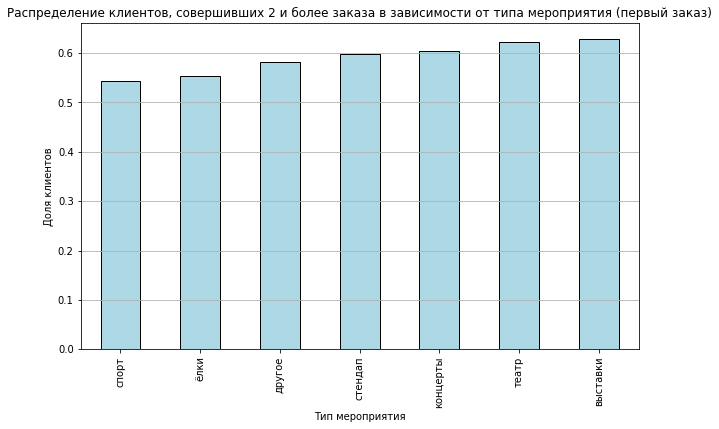

In [102]:
plt.figure(figsize=(10,6))

user_profile.groupby('event_type_f')['is_two'].mean().sort_values().plot(kind='bar',color='lightblue',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля клиентов')
plt.grid(axis='y')

plt.show()

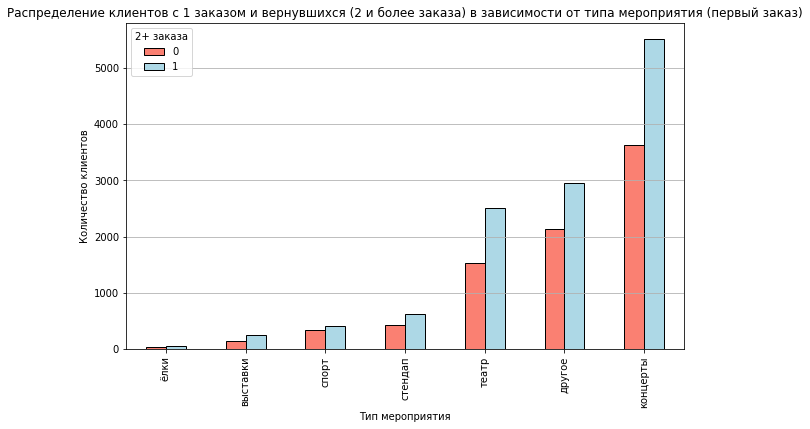

In [103]:
user_profile.groupby('event_type_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='bar', figsize=(10,6),color=['salmon', 'lightblue'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество клиентов')
plt.grid(axis='y')
plt.legend(title='2+ заказа')

plt.show()

Примерно 63% пользователей совершают повторные заказы, если их первые приобретенные билеты на мероприятия типов "выставки" и "театр". 61% пользователей возвращаются повторно после приобретения билетов на "концерты" и "стендап". Но учитывая размер выборок (клиентов, заказавших билеты впервые на концерты и театр, больше, чем пользователей в других типах мероприятий), можно говорить о том, что значимые проценты пользователей с повторными заказами у типов - "концерт" и "театр".   
Меньше всего совершают повторные покупки пользователи, у которых тип первого мероприятия был "спорт" (около 57%), "елки" (около 58%) и категория "другое" (около 60%)

Более 5 тыс. пользователей вернулись на Яндекс Афишу после приобретенных впервые билетов на концерты. Около 2,5 тыс. и 3 тыс. вернувшихся пользователей для типов первого мероприятия "театр" и "другое".

Сегмент пользователей **по типу устройства, с которого совершена первая покупка**, совершившие 2 и более заказа:

In [104]:
user_profile.groupby('device_type_f')['is_two'].mean()

device_type_f
desktop    0.623143
mobile     0.594656
Name: is_two, dtype: float64

Среди пользователей, совершивших первый заказ с мобильного устройства (таких пользователей 16 688), около 60% совершили 2 и более заказа. Около 64% пользователей, совершивших первый заказ со стационарного устройства, сделали 2 и более заказа.  

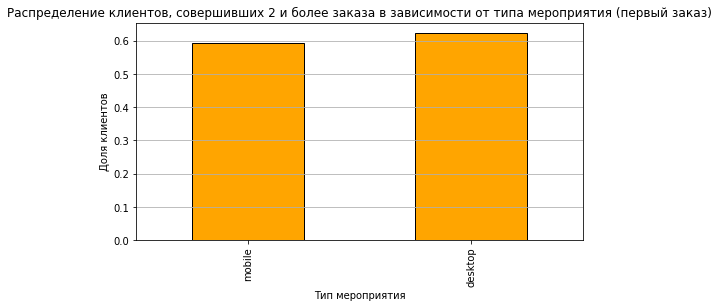

In [105]:
plt.figure(figsize=(8,4))

user_profile.groupby('device_type_f')['is_two'].mean().sort_values().plot(kind='bar',color='orange',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля клиентов')
plt.grid(axis='y')

plt.show()

Поскольку основная масса пользователей совершала свой первый заказ с мобильного устройства, но доли повторно возвращающихся пользователей примерно одинаковы для двух видов устройств, имеет смысл отобразить на графике и процент пользователей, которые сделали всего 1 заказ: 

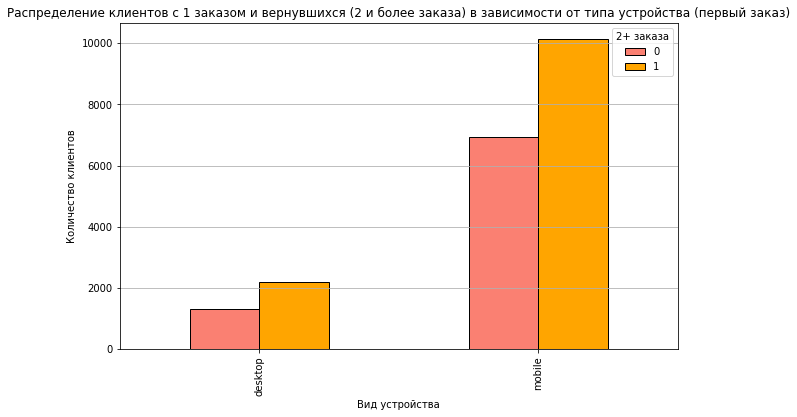

In [106]:
user_profile.groupby('device_type_f')['is_two'].value_counts().unstack(fill_value=0).plot(kind='bar',figsize=(10,6),color=['salmon', 'orange'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от типа устройства (первый заказ)')
plt.xlabel('Вид устройства')
plt.ylabel('Количество клиентов')
plt.grid(axis='y')
plt.legend(title='2+ заказа')

plt.show()

Более 10 тыс. пользователей сделали 2 и более заказа, когда тип устройства при их первом заказе было мобильное устройство. И более 2 тыс. пользователей сделали 2 и болеее заказа, при использовании в первом заказе стационарного устройства. 
Но при этом, если сравнивать доли, то доля возвращающихся повторно клиентов будет на 4% больше для стационарного устройства, нежели для мобильного.
Соответственно, тип используемого при первом заказе устройства особого влияния на повтор заказа в будущем не оказывает. 

Сегмент пользователей **по региону проведения мероприятия из первого заказа**, совершившие 2 и более заказа:

In [107]:
# Определяю топ-10 регионов по количеству пользователей
top_regions = user_profile['region_f'].value_counts().head(10).index

# Вывод количества пользователей, совершивших повторные заказы, по регионам
user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].mean().sort_values(ascending=False)

region_f
Шанырский регион        0.645022
Светополянский округ    0.640553
Широковская область     0.638462
Североярская область    0.624365
Речиновская область     0.617225
Каменевский регион      0.609426
Травяная область        0.602151
Яблоневская область     0.588832
Малиновоярский округ    0.549902
Озернинский край        0.545732
Name: is_two, dtype: float64

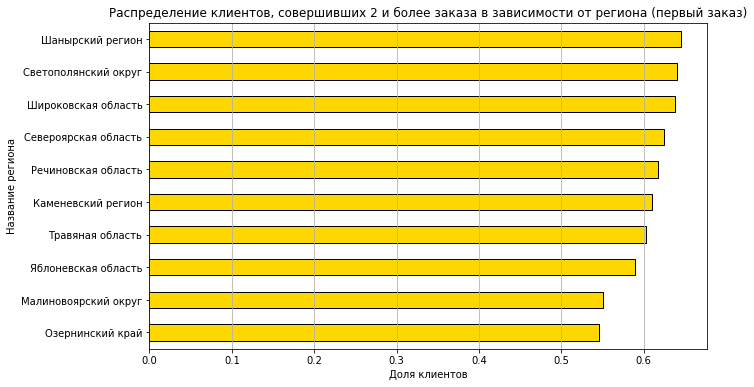

In [108]:
plt.figure(figsize=(10,6))

user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].mean().sort_values(ascending=True).plot(kind='barh',color='gold',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от региона (первый заказ)')
plt.xlabel('Доля клиентов')
plt.ylabel('Название региона')
plt.grid(axis='x')

plt.show()

Среди клиентов, совершивших 2 и более заказа, распределение по регионам достаточно равномерное — доли повторных покупателей в каждом регионе близки друг к другу, без выраженных резких перепадов. Это говорит о том, что лояльные клиенты присутствуют во всех регионах, и повторные покупки не сконцентрированы в каком-то одном географическом сегменте.
Лидирующими регионами по проценту возврата являются: Шанырский регион (около 65%), Светополянский округ и Широковская область (около 64%). Самые низкие проценты возврата у Малиновоярского округа и Озернинского края (около 54%)

Поскольку регионы (первая покупка) представлены различным количеством клиентов, необходимо построить следующую визуализацию:

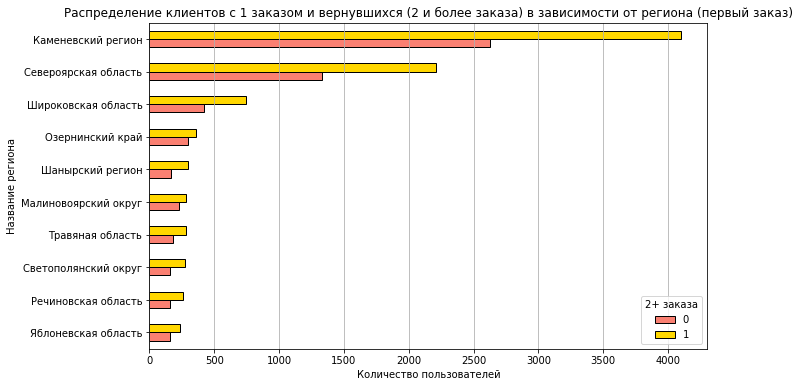

In [109]:
user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='barh',figsize=(10,6),color=['salmon', 'gold'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от региона (первый заказ)')
plt.xlabel('Количество пользователей')
plt.ylabel('Название региона')
plt.grid(axis='x')
plt.legend(title='2+ заказа')

plt.show()

Распределение количества пользователей по регионам остаётся неравномерным: Каменевский регион лидирует по общему числу клиентов, включая тех, кто совершил повторные покупки. Однако доля возврата (соотношение между пользователями с одним заказом и с 2+ заказами) варьируется между регионами. Некоторые регионы, несмотря на умеренное общее количество клиентов, демонстрируют высокую долю возврата — например, Шанырский и Светополянский округа. Получается, что лояльность клиентов не всегда коррелирует с их численностью в регионе.

Сегмент пользователей **по билетному оператору, продавшему билеты на первый заказ**:

In [110]:
# Определяю топ-10 билетных операторов по количеству пользователей
top_services = user_profile['service_name_f'].value_counts().head(10).index

# Вывод количества пользователей, совершивших повторные заказы, по билетным операторам (топ-10)
user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].mean().sort_values(ascending=False)

service_name_f
Край билетов          0.637615
Дом культуры          0.635015
Весь в билетах        0.614566
Билеты в руки         0.608316
Прачечная             0.606227
Облачко               0.601335
Лучшие билеты         0.598573
Лови билет!           0.597393
Мой билет             0.593286
Билеты без проблем    0.591345
Name: is_two, dtype: float64

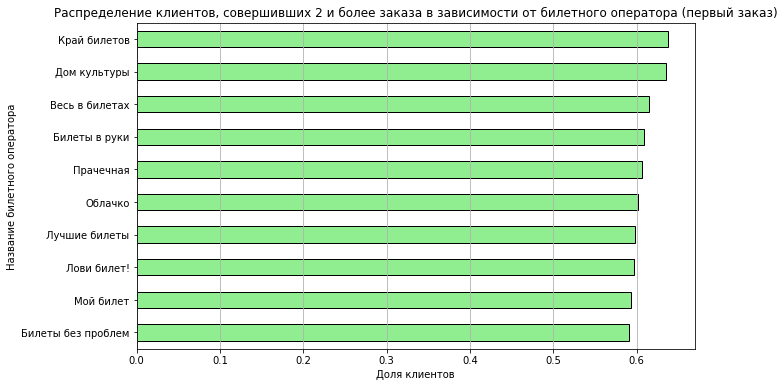

In [111]:
plt.figure(figsize=(10,6))

user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].mean().sort_values(ascending=True).plot(kind='barh',color='lightgreen',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от билетного оператора (первый заказ)')
plt.xlabel('Доля клиентов')
plt.ylabel('Название билетного оператора')
plt.grid(axis='x')

plt.show()

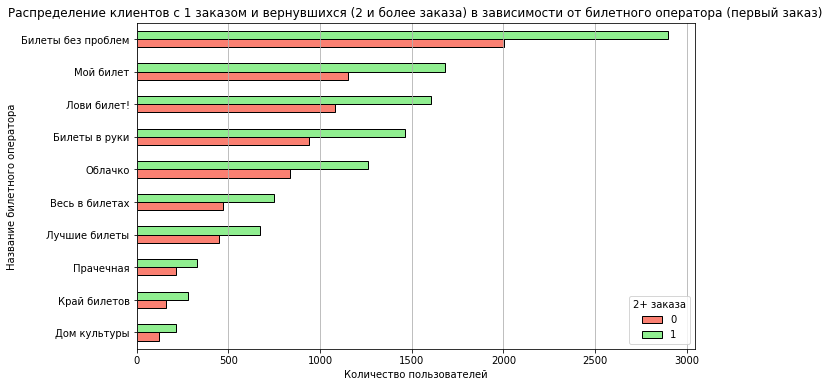

In [112]:
user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='barh',figsize=(10,6),color=['salmon', 'lightgreen'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от билетного оператора (первый заказ)')
plt.xlabel('Количество пользователей')
plt.ylabel('Название билетного оператора')
plt.grid(axis='x')
plt.legend(title='2+ заказа')

plt.show()

Наивысшая доля возврата наблюдается у операторов «Край билетов» (63.8%) и «Дом культуры» (63.5%), но по численности клиентов они уступают другим. Операторы «Весь в билетах», «Билеты в руки», «Прачечная», «Облачко» — находятся в диапазоне 60–61%, что также свидетельствует о стабильной лояльности и небольшом проценте отрыва от лидирущих билетных операторов. Нижняя часть рейтинга — «Лучшие билеты», «Лови билет!», «Мой билет», «Билеты без проблем» — с долей возврата около 59–59.1%. Разница с лидерами составляет около 4–5 процентов. Но при этом они имеют большую клиентскую базу, это может указывать на массовый, но менее удерживаемый трафик. 
Высокая доля возврата не всегда совпадает с большим количеством клиентов. Некоторые операторы работают с более узкой, но лояльной аудиторией, а крупные платформы — с широкой, но менее стабильной.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1:** 

Доля возврата после первого заказа на спортивные мероприятия — около 57%, тогда как после концертов — около 61%. Это означает, что пользователи, начавшие с концертов, возвращаются чаще, чем те, кто начал со спорта. Кроме того, абсолютное число возвратившихся клиентов после концертов — более 5 тыс., что делает этот тип первого посещенного мероприятия не только более лояльным, но и более массовым.  
Тип мероприятия действительно влияет на вероятность возврата, но в обратную сторону, чем предполагает эта гипотеза:
концерты стимулируют повторные покупки чаще, чем спортивные события.

**Гипотеза 1 не подтверждается**

**Гипотеза 2:**

Анализ графика "Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от региона (первый заказ)", отображающего абсолютные значения показывает, что в крупных регионах — например, Каменевском — действительно больше клиентов и больше повторных заказов в числах. Однако другой график "Распределение клиентов, совершивших 2 и более заказа в зависимости от региона (первый заказ)", отображающего относительные значения демонстрирует, что доля возврата по регионам распределена равномерно, без выраженной зависимости от размера пользовательской базы.  
Это означает, что высокая численность клиентов не гарантирует более высокую лояльность. Некоторые менее активные регионы показывают сопоставимые или даже более высокие доли возврата.  
Следовательно, повторные покупки зависят не столько от общего числа клиентов (их первых заказов) в регионе, сколько от других факторов.

**Гипотеза 2 не подтверждается**

### Промежуточный вывод:

**Задача 4.1.1: Исследование признаков, описывающих первый заказ пользователя, и их влияние на вероятность возвращения пользователя**

Распределение пользователей по сегментам неравномерное, и в данных явно выделяются выраженные «точки входа»:   
- Тип мероприятия: концерты — главный канал привлечения, через них впервые пришли почти половина пользователей (44%)
- Тип устройства: мобильный телефон — доминирующий канал первой покупки (83%), что подтверждает его роль как основной точки входа
- Регионы: Каменевский регион выделяется как крупнейший сегмент (32%)
- Билетные операторы: «Билеты без проблем» лидирует (24%)

Таким образом, данные показывают, что пользователи концентрируются вокруг нескольких ключевых сегментов — концертов, мобильных устройств, отдельных регионов и ведущих билетных операторов. Это подтверждает наличие выраженных точек входа, а не равномерное распределение.

**Задача 4.1.2: Анализ возвратов пользователей**

Анализ разных сегментов показывает, что во всех сегментах вероятность повторного заказа находится примерно на одном уровне, без резких провалов или экстремальных пиков. Ни один фактор (тип мероприятия, устройство, регион, оператор) не оказывает кардинального влияния на возврат. Однако можно выделить лидеров и аутсайдеров в каждом сегменте:  
- Тип мероприятия: самые высокие доли возврата у "выставок" и "театра" (около 63%), а также у "концертов" и "стендапа" (около 61%). При этом именно "концерты" и "театр" дают значимые абсолютные числа возвратов (тысячи клиентов). Минимальная лояльность у "спорта" (около 57%) и "ёлок" (около 58%), но при этом сегмент "ёлки" представлен очень малым числом пользователей, поэтому доля может быть не стабильна.

- Тип устройства: пользователи со стационарных устройств возвращаются чуть чаще (+4%), чем пользователи, совершившие свой первый заказ с мобильного устройства.

- Регион: доли возврата распределены равномерно, лояльность есть во всех регионах. Лидеры по проценту возврата — Шанырский и Светополянский округа (около 64–65%), но численность клиентов не всегда коррелирует с их вероятностью совершить повторный заказ. Самые низкие проценты возврата у Малиновоярского округа и Озернинского края (около 54%)

- Билетные операторы: "Край билетов" и "Дом культуры" лидируют по доле возврата (около 63%), но имеют небольшую клиентскую базу (по первому заказу). Крупные операторы ("Билеты без проблем", "Мой билет", "Лови билет!") обеспечивают массовый поток клиентов, но с более низкой лояльностью (около 59%).

**Задача 4.1.3: Проверка продуктовых гипотез**
- *Гипотеза 1: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.*

Не подтверждается. Концерты стимулируют повторные покупки чаще, чем спортивные события.
- *Гипотеза 2: в регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.* 

Не подтверждается. Высокая численность клиентов не гарантирует более высокие проценты возврата. Некоторые менее активные регионы показывают сопоставимые или даже более высокие доли возврата.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


Cравнение статистик поля `avg_revenue` для пользователей, совершивших 1 заказ и совершивших 2+ заказа:

In [113]:
user_profile.groupby('is_two')['avg_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
is_two,,,,,,,,
0,8237.0,541.799438,516.599792,-10.770,130.000000,374.160004,823.929993,2628.419922
1,12330.0,545.904175,376.038696,-5.385,260.708214,493.885834,760.776962,2628.419922


Гистограмма распределения средней выручки с заказа для пользователей, совершивших один заказ:

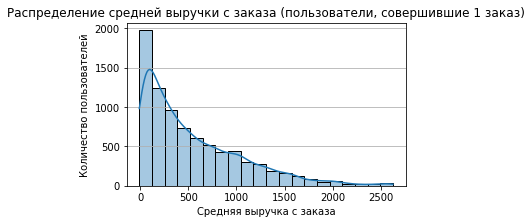

In [114]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==0], x='avg_revenue', bins=20,alpha=0.4,kde=True)

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 1 заказ)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Гистограмма распределения средней выручки с заказа для пользователей, совершивших 2 и более заказа:

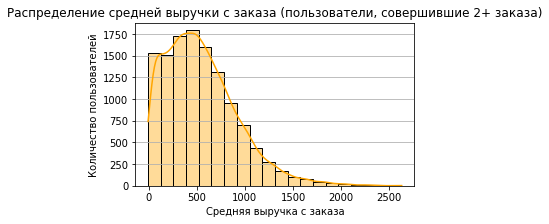

In [115]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==1], x='avg_revenue', bins=20,alpha=0.4,kde=True,color='orange')

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 2+ заказа)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

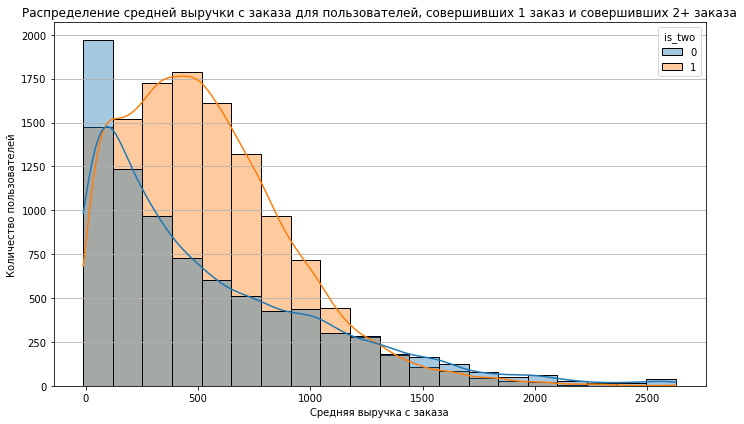

In [116]:
plt.figure(figsize=(10,6))

sns.histplot(data=user_profile, x='avg_revenue', bins=20,alpha=0.4,kde=True,hue='is_two')

plt.title('Распределение средней выручки с заказа для пользователей, совершивших 1 заказ и совершивших 2+ заказа')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.tight_layout()

plt.show()

Пользователи с одним заказом (cиний график):  
Основной пик KDE находится в диапазоне от 0 до 200 руб. средней выручки. Это указывает на то, что большинство таких пользователей совершают недорогие покупки. Имеется пик около значения 0, свидетельствующий о большом количестве клиентов, купивших билеты, стоимость которых принесла сервису околонулевую выручку.

Пользователи с двумя и более заказами (оранжевый график):  
Распределение смещено вправо, с пиком в диапазоне от 300 до 700 единиц. Это говорит о более высоком среднем чеке у лояльных пользователей, совершающих повторные покупки.  
Пользователи с 2+ заказами приносят значительно больше выручки за заказ, чем те, кто сделал только один.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


Cравнение статистик поля `avg_revenue` для пользователей, совершивших 2-4 заказа и совершивших 5+ заказов:

In [117]:
user_profile[user_profile['is_two']==1]['avg_revenue'].describe()

count    12330.000000
mean       545.904175
std        376.038696
min         -5.385000
25%        260.708214
50%        493.885834
75%        760.776962
max       2628.419922
Name: avg_revenue, dtype: float64

In [118]:
user_profile[user_profile['is_five']==1]['avg_revenue'].describe()

count    5236.000000
mean      541.360291
std       312.332825
min         0.000000
25%       316.518745
50%       514.385254
75%       728.085266
max      2299.867432
Name: avg_revenue, dtype: float64

Выше на предыдущем графике (оранжевый цвет) была построена гистограмма распределения значений средней выручки для клиентов с 2+ заказами. Ниже представлен повтор этого графика, чтобы оценить его форму для дальнейшего сравнения:

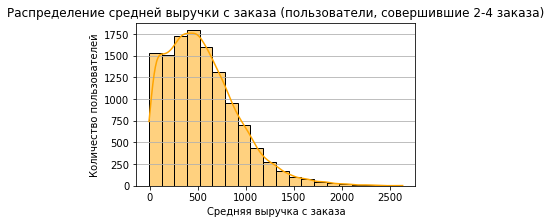

In [119]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==1], x='avg_revenue', bins=20,alpha=0.5,kde=True,color='orange')
plt.title('Распределение средней выручки с заказа (пользователи, совершившие 2-4 заказа)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Гистограмма распределения средней выручки с заказа для пользователей, совершивших 5 и более заказов:

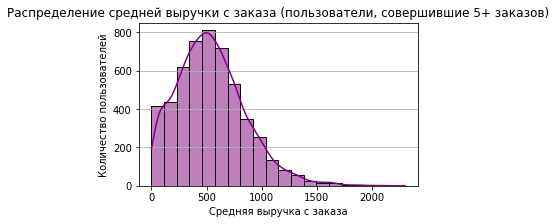

In [120]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_five']==1], x='avg_revenue', bins=20,alpha=0.5,kde=True,color='purple')

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 5+ заказов)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Два графика вместе в одном масштабе:

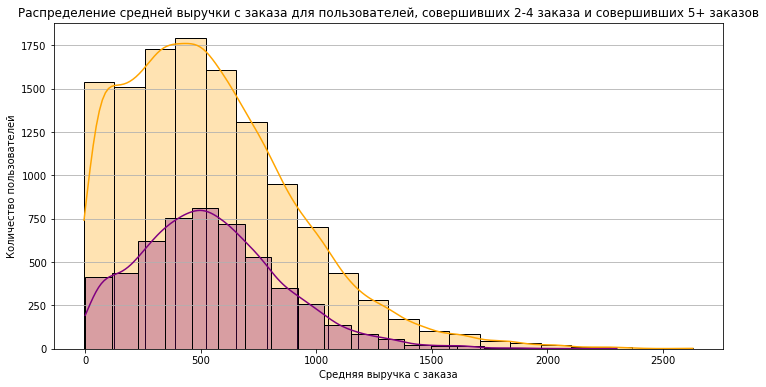

In [121]:
fig, axes = plt.subplots(figsize=(12, 6))

# Первый график (оранжевый): пользователи с 2-4 заказами
sns.histplot(data=user_profile[user_profile['is_two'] == 1],x='avg_revenue',bins=20,kde=True,color='orange',alpha=0.3)

# Второй график (сиреневый): пользователи с 5+ заказми
sns.histplot(data=user_profile[user_profile['is_five'] == 1],x='avg_revenue',bins=20,kde=True,color='purple',alpha=0.3)

plt.title('Распределение средней выручки с заказа для пользователей, совершивших 2-4 заказа и совершивших 5+ заказов')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()


Различия между пользователями с 2–4 заказами и пользователями с 5+ заказами по средней выручке с заказа присутствуют, но они не такие выраженные, как различия между пользователями с 1 заказом и с 2-4 заказами:

Пользователи с 2–4 заказами (оранжевый график) демонстрируют более сфокусированное распределение: основной пик KDE находится в диапазоне от 300 до 600 руб.  
Пользователи с 5 и более заказами (сиреневый график) имеют более размазанное и широкое распределение (пик более пологий), с пиком, охватывающим диапазон от 300 до 700 рублей. Это может свидетельствовать о большей вариативности в поведении — часть пользователей делает более дорогие покупки, часть остаётся в среднем сегменте. После пика не наблюдается заметное снижение (спад), как на оранжевом графике, а более пологое снижение численности пользователей.  Что говорит о концентрации в относительно узком сегменте среднего чека для пользователей с 2-4 заказами. А для пользователей с 5+ заказами это означает, что внутри этой группы существует широкий спектр уровней выручки, и пользователи распределены более равномерно по диапазону 300–700 рублей и выше.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Разделение пользователей на несколько сегментов по среднему количеству билетов в заказе:

In [122]:
# Задам функцию, которая сегментирует пользователей по среднему количеству билетов в заказе
def segment_avg_tickets(value):
    if 1 <= value < 2:
        return '1–2 билета'
    elif 2 <= value < 3:
        return '2–3 билета'
    elif 3 <= value < 5:
        return '3–5 билетов'
    elif value >= 5:
        return '5+ билетов'

user_profile['segment_avg_tickets'] = user_profile['avg_tickets'].apply(segment_avg_tickets)

user_profile[['avg_tickets','segment_avg_tickets']].head()

,avg_tickets,segment_avg_tickets
0,4.000000,3–5 билетов
1,3.000000,3–5 билетов
2,2.666667,2–3 билета
3,4.000000,3–5 билетов
4,1.500000,1–2 билета


Общее число пользователей и доля пользователей, совершивших повторные заказы:

In [123]:
user_profile.groupby('segment_avg_tickets')['is_two'].sum().sort_values(ascending=False)

segment_avg_tickets
2–3 билета     6250
3–5 билетов    4782
1–2 билета     1237
5+ билетов       61
Name: is_two, dtype: int64

In [124]:
user_profile.groupby('segment_avg_tickets')['is_two'].mean().sort_values(ascending=False)

segment_avg_tickets
2–3 билета     0.713552
3–5 билетов    0.535738
1–2 билета     0.512215
5+ билетов     0.130621
Name: is_two, dtype: float64

В сегменте, где у пользователя в среднем 2-3 билета в заказе, находится и наибольшее количество клиентов, и их доля возврата составляет около 71%. Сегменты "3-5 билетов" и "1-2" по проценту возврата приблизительно одинаковы (около 54% и 51 %). Сегмент 5+ билетов представлен малым количеством пользователей, поэтому сложно оценить корректную долю возврата в этом случае.

Пользователи распределены по сегментам неравномерно. Основное количество пользователей, совершившие повторные заказы, находятся в сегменте "2-3 билета" и "3-5 билетов".

Распределение пользователей, совершивших повторный заказ, в зависимости от сегмента (по среднему количеству билетов в заказе):

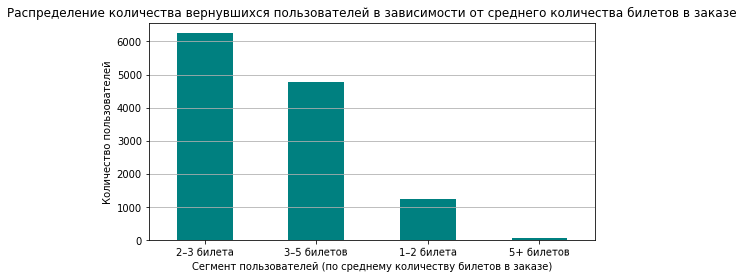

In [125]:
plt.figure(figsize=(8,4))

user_profile.groupby('segment_avg_tickets')['is_two'].sum().sort_values(ascending=False).plot(kind='bar', rot=0.45,color='teal')

plt.title('Распределение количества вернувшихся пользователей в зависимости от среднего количества билетов в заказе')
plt.xlabel('Сегмент пользователей (по среднему количеству билетов в заказе)')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

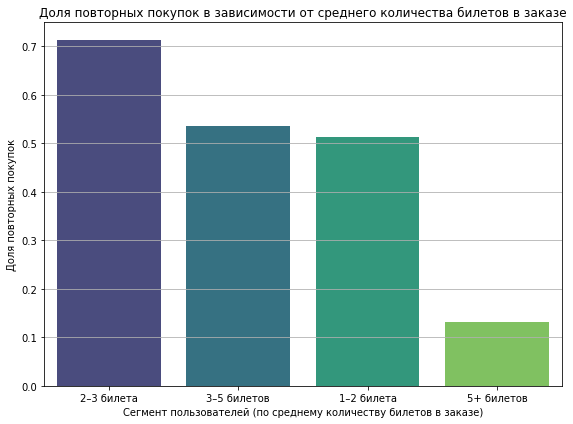

In [126]:
segment_means = user_profile.groupby('segment_avg_tickets')['is_two'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=segment_means.index, y=segment_means.values, palette='viridis')

plt.title('Доля повторных покупок в зависимости от среднего количества билетов в заказе')
plt.ylabel('Доля повторных покупок')
plt.xlabel('Сегмент пользователей (по среднему количеству билетов в заказе)')
plt.grid(axis='y')
plt.tight_layout()

plt.show()


Распределение пользователей неконцентрированное и неравномерное:  
сегмент "2–3 билета" — самый крупный, здесь сосредоточено наибольшее количество клиентов, что делает его основной группой по объёму. Сегменты "1–2 билета" и "3–5 билетов" представлены умеренно — они уступают по численности. Сегмент "5+ билетов" — наименее представленный, его доля в пользовательской базе минимальна.

Аномально высокая доля возврата наблюдается у пользователей с 2–3 билетами в заказе: около 71% совершают повторные покупки. Это самый лояльный сегмент, сочетающий массовость и высокий возврат. У сегментов "1–2 билета" и "3–5 билетов": около 51–54%. Поведение этих групп близкое, без резких отклонений. Аномально низкая доля возврата — у пользователей с 5+ билетами: около 13% совершают повторные покупки.

### Промежуточный вывод:

**Задача 4.2.1: Cвязь между средней выручкой сервиса с заказа и повторными заказами**

Пользователи с одним заказом имеют сновной пик в диапазоне от 0 до 200 руб. средней выручки. Большинство таких пользователей совершают недорогие покупки, а также приобретают билеты, стоимость которых принесла сервису околонулевую выручку.  
Для пользователей с двумя и более заказами распределение с пиком расположено в диапазоне от 300 до 600 руб. Это говорит о более высоком среднем чеке у лояльных пользователей, совершающих повторные покупки.  
Пользователи с 2+ заказами приносят значительно больше выручки за заказ, чем те, кто сделал только один.  
Таким образом, пользователи, совершающие повторные покупки, приносят значительно больше выручки за заказ, чем те, кто сделал только один. Это подчёркивает важность удержания клиентов и развития лояльности.


**Задача 4.2.2: Сравнение распределение по средней выручке с заказа в двух группах пользователей: совершивших 2–4 заказа и совершивших 5 и более заказов**

Различия между пользователями с 2–4 заказами и пользователями с 5+ заказами по средней выручке с заказа присутствуют, но они не такие выраженные, как различия между пользователями с 1 заказом и с 2-4 заказами.  
Пользователи с 5 и более заказами имеют более размазанное и широкое распределение, с пиком, охватывающим диапазон от 350 до 700 рублей. Это может свидетельствовать о большей вариативности в поведении — часть пользователей делает более дорогие покупки, часть остаётся в среднем сегменте. После пика не наблюдается заметное снижение (спад), а более пологое снижение численности пользователей, что говорит о концентрации в относительно узком сегменте среднего чека для пользователей с 2-4 заказами и в более широком сегменте пользователей с 5+ заказами.  
Хотя оба сегмента имеют пересекающиеся диапазоны средней выручки, пользователи с 5+ заказами демонстрируют более разнообразные паттерны потребления. Их распределение шире, что может указывать на наличие как премиальных клиентов, так и тех, кто делает частые, но недорогие покупки. В то время как пользователи с 2–4 заказами более однородны по уровню выручки.

**Задача 4.2.3: Влияние среднего количества билетов в заказе на вероятность повторной покупки**

Распределение пользователей по сегментам неравномерное: основная масса клиентов находится в группе с 2–3 билетами (6250 пользователей), далее следуют сегменты  "3-5 билетов" (4782 пользователя) и "1-2 билета" (1237 пользователя), а группа 5+ билетов — минимальна (61 пользователь). Сегмент "2–3 билета" демонстрирует наивысшую долю повторных покупок (около 71%), что делает его самым лояльным. Поведение групп "1–2 билета" и "3–5 билетов" схожее (51–54%). Низкий возврат в сегменте 5+ билетов (13%) сложно интерпретировать, поскольку этот сегмент малочисленный, и доля может быть нестабильной.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Для удобства последующей группировки и построения визуализаций добавляю в датафрейм <u>user_profile</u> дополнительный столбец с выделенным номером недели из столбца с датой первой покупки `first_order`:

In [127]:
# Прибавляю единицу, чтобы сделать привычный вид, где понедельник - 1, а воскресенье - 7
user_profile['first_order_day'] = user_profile['first_order'].dt.day_of_week + 1

Общее число пользователей, совершивших повторные заказы, в зависимости от номера дня недели:

In [128]:
user_profile[user_profile['is_two'] == 1]['first_order_day'].value_counts()

6    1876
5    1851
2    1802
3    1794
4    1755
1    1726
7    1526
Name: first_order_day, dtype: int64

Суббота и пятница — дни, когда клиенты, совершившие первую покупку, больше всего возвращаются. Минимальное число возвратов - в воскресенье. Вторник, среда, четверг, понедельник находятся в середине диапазона.

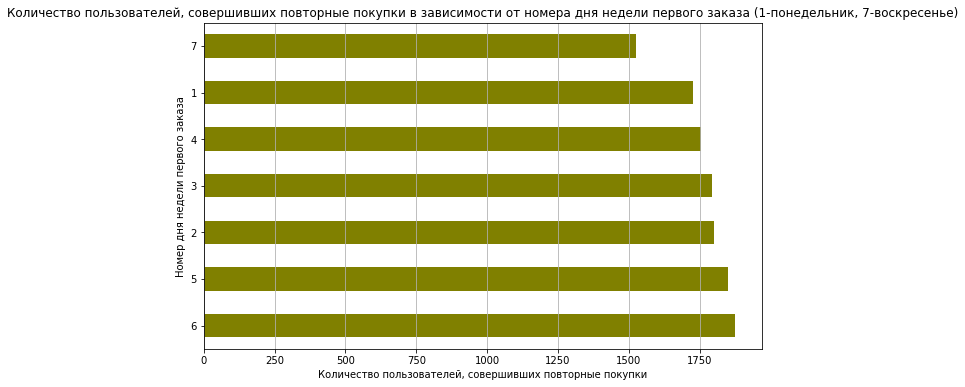

In [129]:
plt.figure(figsize=(10,6))

user_profile.groupby('first_order_day')['is_two'].sum().sort_values(ascending=False).plot(kind='barh',color='olive')

plt.title('Количество пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.ylabel('Номер дня недели первого заказа')
plt.xlabel('Количество пользователей, совершивших повторные покупки')
plt.grid(axis='x')

plt.show()

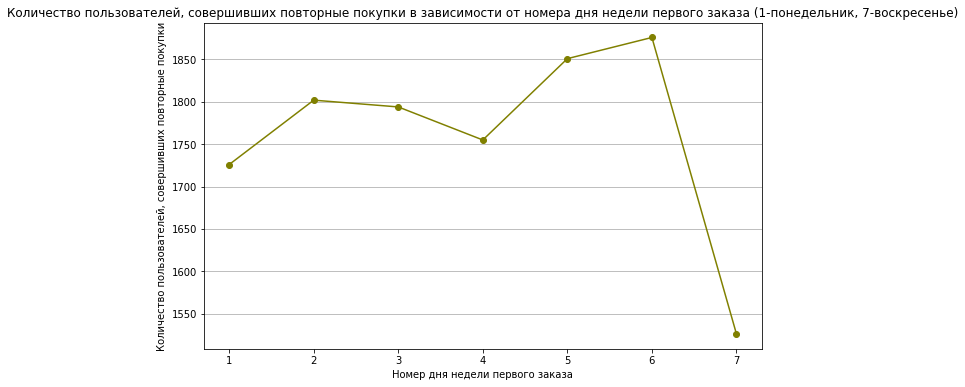

In [130]:
plt.figure(figsize=(10,6))

plt.plot(range(1,8),user_profile[user_profile['is_two'] == 1]['first_order_day'].value_counts().sort_index().values,marker='o',color='olive')

plt.title('Количество пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.xlabel('Номер дня недели первого заказа')
plt.ylabel('Количество пользователей, совершивших повторные покупки')
plt.grid(axis='y')

plt.show()

Визуализация выше также подтверждает, что люди, совершающие первую покупку в субботу, чаще возвращаются. Это может говорить о более осознанных покупках в выходные, когда у клиентов больше времени.

Воскресенье — самый слабый день для удержания. Возможно, в воскресенье клиенты совершают импульсивные заказы, не планируя возвращаться. Или это могут быть остатки рекламных кампаний.

Доля пользователей, совершивших повторные заказы, в зависимости от номера дня недели:

In [131]:
user_profile.groupby('first_order_day')['is_two'].mean().sort_values(ascending=False)

first_order_day
1    0.617310
3    0.612287
6    0.606335
2    0.601870
5    0.589490
4    0.584805
7    0.584227
Name: is_two, dtype: float64

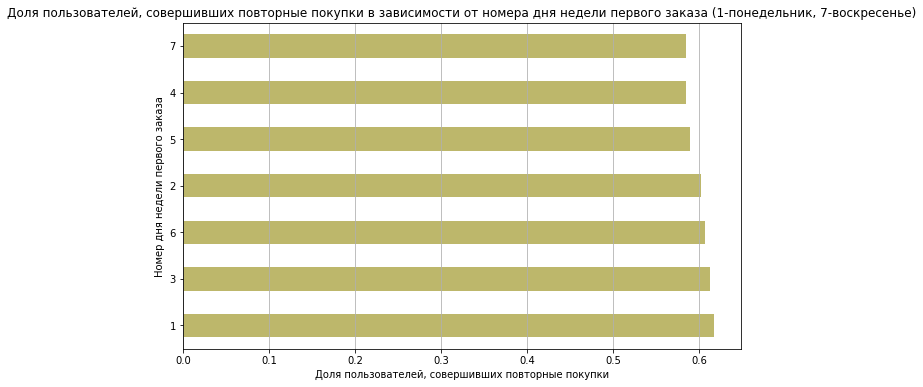

In [132]:
plt.figure(figsize=(10,6))

user_profile.groupby('first_order_day')['is_two'].mean().sort_values(ascending=False).plot(kind='barh',color='darkkhaki')

plt.title('Доля пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.ylabel('Номер дня недели первого заказа')
plt.xlabel('Доля пользователей, совершивших повторные покупки')
plt.grid(axis='x')

plt.show()

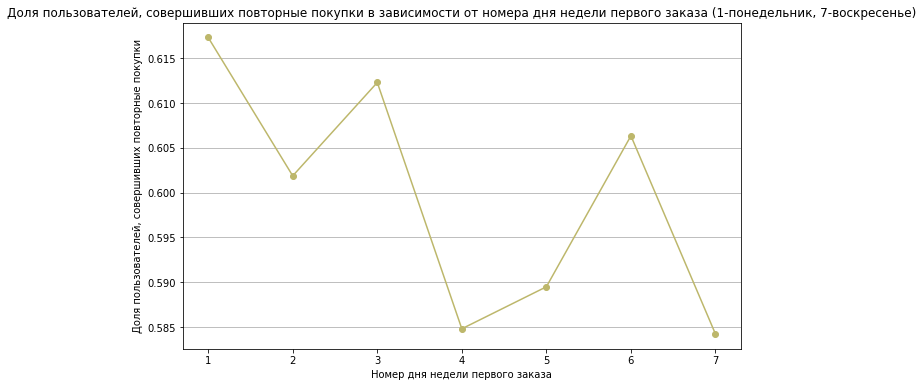

In [133]:
plt.figure(figsize=(10,6))

plt.plot(range(1,8),user_profile.groupby('first_order_day')['is_two'].mean().sort_index().values,marker='o',color='darkkhaki')

plt.title('Доля пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.xlabel('Номер дня недели первого заказа')
plt.ylabel('Доля пользователей, совершивших повторные покупки')
plt.grid(axis='y')

plt.show()

Понедельник — лидер по лояльности. Хотя по абсолютному числу возвратов (из данных выше) понедельник был ближе к нижней части списка, по доле он на первом месте. Это значит, что клиенты, пришедшие в понедельник, чаще возвращаются, несмотря на то, что их было меньше. Возможно, это клиенты, совершающие обдуманные и осознанные покупки в начале рабочей недели.

Суббота — не самая лояльная,поскольку по количеству возвратов суббота была на первом месте, но по доле — только третья. Это может говорить о большом трафике, но не обязательно о высоком качестве: часть клиентов могла быть случайной или пришла по акции.

Воскресенье — самый слабый день по всем метрикам: и по количеству, и по доле — самый низкий результат.

Клиенты, совершившие первую покупку в среду, возвращаются почти так же часто, как и те, кто начал в понедельник. Это говорит о высоком качестве аудитории в середине недели.В отличие от выходных, где наблюдаются сильные колебания (суббота — много клиентов, но не самая высокая доля; воскресенье — минимум по всем метрикам), середина недели показывает устойчивую и надёжную конверсию в повторные заказы. Среда может быть днём, когда клиенты совершают более осознанные покупки — не импульсивные, а плановые. Это повышает вероятность возврата.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Среднее время между заказами для пользователей, совершивших 2-4 заказа:

In [134]:
user_profile[user_profile['is_two']==1]['avg_time'].mean().round(2)

17.06

Среднее время между заказами для пользователей, совершивших 5+ заказов:

In [135]:
user_profile[user_profile['is_five']==1]['avg_time'].mean().round(2)

11.14

Для пользователей, которые совершают 2-4 заказа, среднее время между заказами составляет 17 дней. У пользователей, совершающих 5 и более заказов среднее время между заказами составляет около 11 дней.

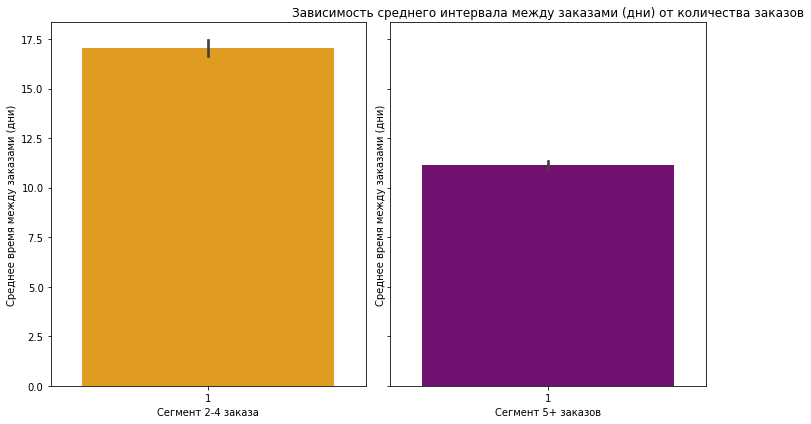

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Первый график (оранжевый): для пользователей с 2-4 заказами
sns.barplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='avg_time',color='orange',ax=axes[0])
axes[0].set_ylabel('Среднее время между заказами (дни)')
axes[0].set_xlabel('Сегмент 2-4 заказа')

# Второй график (сиреневый): для пользоватеелй с 5+ заказами
sns.barplot(data=user_profile[user_profile['is_five'] == 1], x='is_five', y='avg_time', color='purple', ax=axes[1])
axes[1].set_ylabel('Среднее время между заказами (дни)')
axes[1].set_xlabel('Сегмент 5+ заказов')

plt.title('Зависимость среднего интервала между заказами (дни) от количества заказов')
plt.tight_layout()

plt.show()

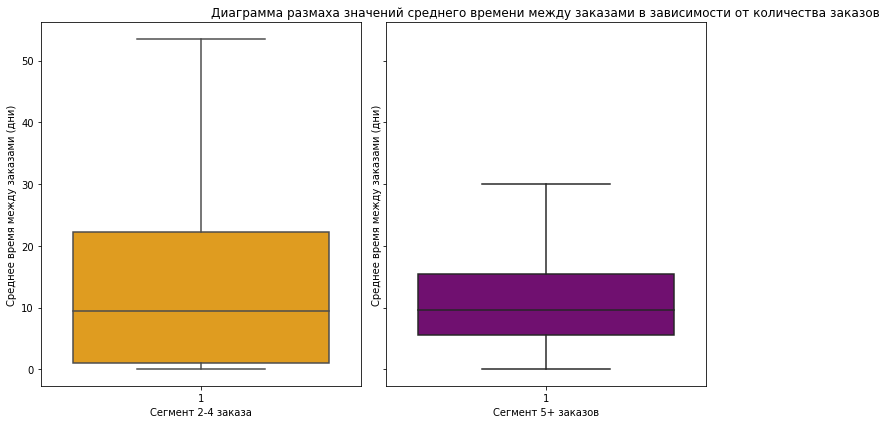

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Первый график для пользователей с 2-4 заказами
sns.boxplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='avg_time',showfliers=False,color='orange',ax=axes[0])
axes[0].set_xlabel('Сегмент 2-4 заказа')
axes[0].set_ylabel('Среднее время между заказами (дни)')

# Второй график для пользоватеелй с 5+ заказами
sns.boxplot(data=user_profile[user_profile['is_five'] == 1],x='is_five',y='avg_time',showfliers=False,color='purple',ax=axes[1])
axes[1].set_xlabel('Сегмент 5+ заказов')
axes[1].set_ylabel('Среднее время между заказами (дни)')

plt.title('Диаграмма размаха значений среднего времени между заказами в зависимости от количества заказов')
plt.tight_layout()

plt.show()


Чем меньше интервал между заказами, тем выше вероятность удержания: пользователи, совершившие 5+ заказов, делают это с меньшим средним интервалом (около 11 дней между заказами), чем те, кто совершил 2–4 заказа (около 17 дней между заказами).  
Клиенты с короткими интервалами между заказами демонстрируют устойчивое поведение и склонность к повторным покупкам. Диаграммы размаха подтверждают это наблюдение: у сегмента с 5+ заказами распределение интервалов более компактное, с меньшим разбросом, тогда как у группы 2–4 заказов наблюдается широкий диапазон, включая длительные паузы между заказами.

**Исследование времени с момента первой покупки — лайфтайм:**

In [138]:
# Создание дополнительного столбца со значением лайфтайма
user_profile['lifetime_days'] = (user_profile['last_order'] - user_profile['first_order']).dt.days

user_profile[['first_order','last_order','lifetime_days']].head()

,first_order,last_order,lifetime_days
0,2024-08-20,2024-08-20,0
1,2024-07-23,2024-10-06,75
2,2024-07-13,2024-10-23,102
3,2024-08-15,2024-08-15,0
4,2024-09-29,2024-10-15,16


In [139]:
user_profile[user_profile['is_two'] == 1]['lifetime_days'].describe()

count    12330.000000
mean        57.295783
std         50.695667
min          0.000000
25%          2.000000
50%         50.000000
75%        105.000000
max        152.000000
Name: lifetime_days, dtype: float64

In [140]:
user_profile[user_profile['is_five'] == 1]['lifetime_days'].describe()

count    5236.000000
mean       88.821047
std        45.694269
min         0.000000
25%        55.000000
50%       100.000000
75%       128.000000
max       152.000000
Name: lifetime_days, dtype: float64

Гистограмма распределения:

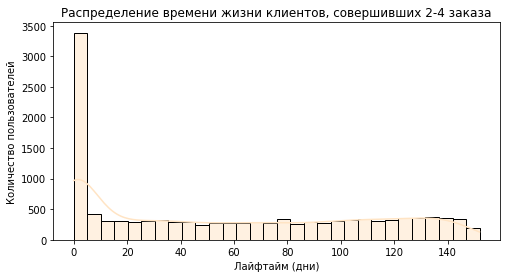

In [141]:
plt.figure(figsize=(8,4))

sns.histplot(user_profile[user_profile['is_two'] == 1]['lifetime_days'],bins=30,kde=True,color='bisque') 

plt.title('Распределение времени жизни клиентов, совершивших 2-4 заказа')
plt.xlabel('Лайфтайм (дни)')
plt.ylabel('Количество пользователей')


plt.show()

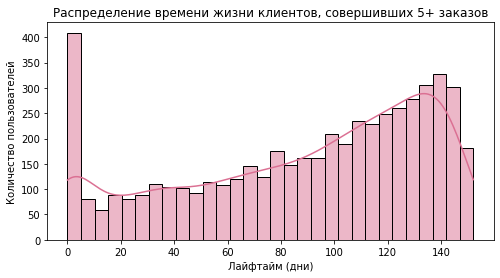

In [142]:
plt.figure(figsize=(8,4))

sns.histplot(user_profile[user_profile['is_five'] == 1]['lifetime_days'],bins=30,kde=True,color='palevioletred') 

plt.title('Распределение времени жизни клиентов, совершивших 5+ заказов')
plt.xlabel('Лайфтайм (дни)')
plt.ylabel('Количество пользователей')


plt.show()

У клиентов с 2–4 заказами: Среднее арифметическое (около 57 дней) больше медианы (50 дней). Разброс значений от 0 до 152 дней. У клиентов с 5+ заказами: Среднее арифметическое (около 89 дней) меньше медианы (100 дней). Разброс точно такой же, как и в сегменте "2-4 заказа". Клиенты с большим числом заказов остаются активными дольше, с более устойчивым лайфтаймом.

Диаграммы размаха значений лайфтайма от количества заказов:

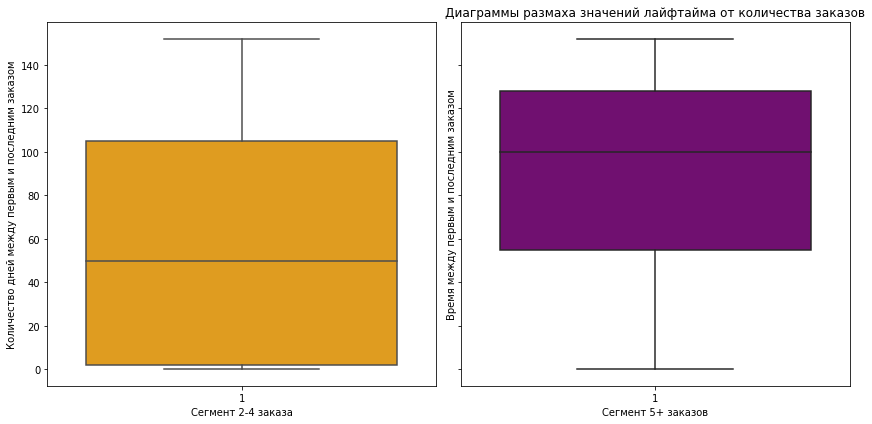

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Первый график для пользователей с 2-4 заказами
sns.boxplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='lifetime_days',showfliers=False,color='orange',ax=axes[0])
axes[0].set_xlabel('Сегмент 2-4 заказа')
axes[0].set_ylabel('Количество дней между первым и последним заказом')

# Второй график для пользоватеелй с 5+ заказами
sns.boxplot(data=user_profile[user_profile['is_five'] == 1],x='is_five',y='lifetime_days',showfliers=False,color='purple',ax=axes[1])
axes[1].set_xlabel('Сегмент 5+ заказов')
axes[1].set_ylabel('Время между первым и последним заказом')

plt.title('Диаграммы размаха значений лайфтайма от количества заказов')
plt.tight_layout()

plt.show()


Клиенты с 5+ заказами имеют более длительный лайфтайм: медиана лайфтайма у этой группы выше, чем у клиентов с 2–4 заказами. Это логично, поскольку чтобы совершить 5+ заказов, нужно больше времени активности. Разброс значений у 2–4 заказов шире, то есть у клиентов с таким количеством заказов лайфтайм варьируется от очень короткого до очень длинного. Это говорит о большей вариативности: часть клиентов быстро перестаёт заказывать, часть остаётся надолго, но не переходит к частым покупкам. 

### Промежуточный вывод:

**Задача 4.3.1: Анализ влияния дня недели, в который была совершена первая покупка, на поведение пользователей**   

По количеству возвратных клиентов лидируют суббота (1876) и пятница (1851), минимальное значение у воскресенья (1526). Будние дни (вторник–четверг) находятся в среднем диапазоне, понедельник чуть ниже.  
Наибольшая доля возвратных клиентов у понедельника (62%) и среды (61%), далее идут суббота и вторник. Наименьшие показатели у воскресенья (58%) и четверга (≈59%).  
Суббота характеризуется максимальным числом возвратов, но по доле занимает лишь третье место. Понедельник и среда не самые большие по числу, но лидеры по доле — более "лояльные" дни. Воскресенье слабый день по обеим метрикам — и по числу, и по доле возвратов.  
Таким образом, данные показывают различие между "популярностью" дня (общее число клиентов) и "качеством" дня (доля возвратов), что позволяет выделить понедельник и среду как наиболее устойчивые по лояльности, а субботу и пятницу — как дни с наибольшим трафиком, но не самой высокой долей возвратов.


**Задача 4.3.2: Влияние среднего интервала между заказами на удержание клиентов**

Чем меньше интервал между заказами, тем выше вероятность удержания: пользователи, совершившие 5+ заказов, делают это с меньшим средним интервалом (около 11 дней между заказами), чем те, кто совершил 2–4 заказа (около 17 дней между заказами). Клиенты с короткими интервалами между заказами демонстрируют устойчивое поведение и склонность к повторным покупкам. Более длинные интервалы могут свидетельствовать о снижении интереса, особенно если клиент не переходит из сегмента 2-4 заказа к 5+ заказам. Средний интервал — важный индикатор удержания, и его сокращение связано с ростом числа заказов и лояльностью клиента.

**Анализ лайфтайма пользователей** :

У клиентов с 2–4 заказами среднее арифметическое (около 57 дней) больше медианы (50 дней). У клиентов с 5+ заказами среднее арифметическое (около 89 дней) меньше медианы (100 дней). Разброс значений одинаков для обоих сегментов. Из этой информации можно заключить, что клиенты с большим числом заказов остаются активными дольше, с более устойчивым лайфтаймом.
Лайфтайм прямо связан с числом заказов: чем больше заказов, тем дольше клиент остаётся активным. Клиенты с 2–4 заказами — менее предсказуемые, среди них есть как быстро исчезающие, так и потенциально лояльные, но не активные. Клиенты с 5+ заказами — устойчивый сегмент с длительным и стабильным лайфтаймом.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [144]:
# Создание корреляционной матрицы
corr_matrix = user_profile[['total_orders','device_type_f','region_f','service_name_f','event_type_f','first_order_day','avg_revenue','avg_tickets','avg_time']].phik_matrix(interval_cols=['avg_revenue','avg_tickets','avg_time'])

correlation_matrix = corr_matrix.loc[corr_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

correlation_matrix

,total_orders
avg_tickets,0.572571
avg_time,0.493222
avg_revenue,0.252211
device_type_f,0.051646
event_type_f,0.033647
region_f,0.000000
service_name_f,0.000000
first_order_day,0.000000


Тепловая карта:

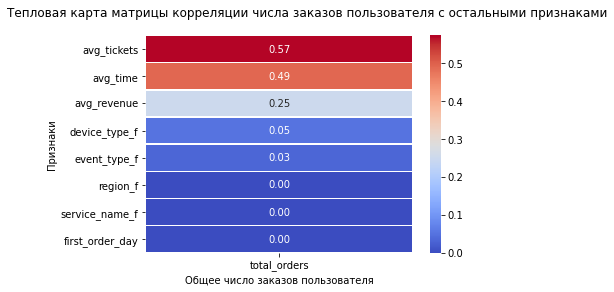

In [145]:
sns.heatmap(data=correlation_matrix,annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm')

plt.suptitle('Тепловая карта матрицы корреляции числа заказов пользователя с остальными признаками')
plt.xlabel('Общее число заказов пользователя')
plt.ylabel('Признаки')

plt.show()

Корреляция различных признаков с общим числом заказов пользователя:

`avg_tickets` — самая сильная корреляция. Среднее количество билетов в заказе тесно связано с общим числом заказов.  
`avg_time` — также значимая связь. Среднее время между заказами влияет на их количество.

`avg_revenue` — умеренная корреляция. Средний доход от клиента связан с числом заказов, но слабее, чем количество билетов и частота покупок.

`device_type_f` и `event_type_f` — очень слабая связь. Тип устройства и тип первого мероприятия практически не влияют на количество заказов.  
`region_f`, `service_name_f`, `first_order_day` — отсутствует корреляция. Регион, билетный оператор и день первого заказа не оказывают влияния на общее число заказов.

Выделяю сегменты пользователей по полю `total_orders`, и повторяю корреляционный анализ:

In [146]:
# Функция, которая сегментирует пользователей по количеству заказов
def segment_avg_orders(value):
    if value ==1:
        return '1 заказ'
    elif 2 <= value <= 4:
        return '2–4 заказа'
    elif value >= 5:
        return '5+ заказов'

user_profile['segment_total_orders'] = user_profile['total_orders'].apply(segment_avg_orders)

user_profile[['total_orders','segment_total_orders']]

,total_orders,segment_total_orders
0,1,1 заказ
1,2,2–4 заказа
2,3,2–4 заказа
3,1,1 заказ
4,2,2–4 заказа
...,...,...
21848,4,2–4 заказа
21849,9,5+ заказов
21850,2,2–4 заказа
21852,1,1 заказ


In [147]:
# Создание новой корреляционной матрицы
corr_matrix = user_profile[['segment_total_orders','device_type_f','region_f','service_name_f','event_type_f','first_order_day','avg_revenue','avg_tickets','avg_time']].phik_matrix(interval_cols=['avg_revenue','avg_tickets','avg_time'])

correlation_matrix = corr_matrix.loc[corr_matrix.index != 'segment_total_orders'][['segment_total_orders']].sort_values(by='segment_total_orders', ascending=False)

correlation_matrix

,segment_total_orders
avg_tickets,0.632733
avg_time,0.380588
avg_revenue,0.299730
region_f,0.105390
service_name_f,0.072021
event_type_f,0.038866
first_order_day,0.022090
device_type_f,0.015515


Тепловая карта:

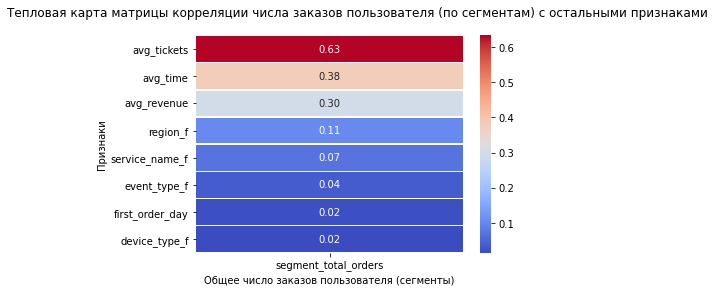

In [148]:
sns.heatmap(data=correlation_matrix,annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm')

plt.suptitle('Тепловая карта матрицы корреляции числа заказов пользователя (по сегментам) с остальными признаками')
plt.xlabel('Общее число заказов пользователя (сегменты)')
plt.ylabel('Признаки')

plt.show()

`avg_tickets` — самая сильная связь. Среднее количество билетов в заказе наиболее сильно связано с тем, в какой сегмент по числу заказов попадает клиент.  
`avg_time` — умеренная связь. Интервалы между заказами влияют на количество заказов. avg_revenue — также умеренная связь. Средний доход от клиента коррелирует с числом заказов, но слабее, чем количество билетов и частота покупок.

`region_f` и `service_name_f` — слабая связь. Регион и билетный оператор оказывают ограниченное влияние на количество заказов.

`event_type_f`, `first_order_day`, `device_type_f`  — практически не связаны с числом заказов. Тип мероприятия, день первого заказа и устройство не определяют количество заказов клиента.

### Промежуточный вывод: 

**Задача 4.4.1: Корреляционный анализ между признаками профиля пользователя и числом заказов total_orders**

Основными факторами, определяющими сегмент клиента по числу заказов, являются среднее количество билетов в заказе (`avg_tickets`) и частота покупок (`avg_time`). Финансовый показатель (`avg_revenue`) играет второстепенную роль. Остальные признаки — регион, оператор, тип мероприятия, устройство и день первого заказа — оказывают минимальное влияние.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Вывод

**Информация об используемых данных**

При выгрузке из базы данных был получен датасет <u>df</u>, включающий в себя информацию о 290 611 заказах и 15 различных признаков. Подготовка к анализу включала в себя: 
- Преобразование типов данных столбцов
- Оптимизацию типов данных столбцов
- Создание дополнительного признака `revenue_rub`, хранящего в себе значения выручки с заказа в российских рублях. Поскольку в датафрейме информация о выручке содержалась в двух валютах (российский рубль, казахстанский тенге), был загружен и использован для конвертации валют датасет <u>df_tenge</u>. 
- Фильтрация данных по значению 99% процентиля выручки в российских рублях. В результате отфильтровано около 1% данных.

Данные представлены для заказов, сделанных с мобильных устройств и стационарных устройств. Заказы были оплачены двумя видами валют: тенге, российский рубль. Билеты приобретались на различные типы мероприятий: выставки, концерты, спорт, стендап, театр, ёлки, другое. Заказы совершались из большого числа различных регионов и городов.

На основе датафрейма <u>df</u> создан датафрейм <u>user_profile</u>, содержащий в себе информацию о пользователях и формирующий профиль пользователя по 13 признакам. До преобразований включал в себя информацию о 21 854 пользователях. 
После исследования статистических характеристик числовых столбцов были проведены:
- Фильтрация данных по значению 95% процентиля количества заказов на одного пользователя
- Фильтрация данных по значению 99% процентиля среднего количества билетов в заказе пользователя
После фильтрации размер датафрейма был уменьшен до 20 567 пользователей (менее 6% данных отфильтровано).

В ходе исследований в <u>user_profile</u> добавлены следующие признаки:
- `segment_avg_tickets` - сегментация пользователей по среднему количеству билетов в заказе
- `first_order_day` - номер дня недели первой покупки 
- `lifetime_days` - лайфтайм пользователя (время между первой и последней покупками)
- `segment_total_orders` - сегментация пользователей по общему количеству заказов

**Исследовательский анализ данных**

В ходе исследования проанализированы данные 20 567 пользователей, средняя выручка с одного заказа - 544 руб., процент пользователей, совершивших 2 и более заказа - 62% , процент пользователей, совершивших 5 и более заказов - 29% .

1. Анализ показал, что признаки первого заказа слабо дифференцируют пользователей по вероятности возврата. В данных нет факторов, которые бы радикально повышали или снижали шанс повторной покупки. Тем не менее, можно выделить умеренные различия:

- Наиболее высокие доли повторных заказов наблюдаются у пользователей, начавших с: выставок и театра (около 63%), концертов и стендапа (около 61%).При этом именно концерты и театр формируют основной абсолютный объём возвратов, так как являются крупнейшими точками входа. Спортивные мероприятия и "ёлки" демонстрируют более низкую лояльность, но в случае "ёлок" выводы ограничены малым размером сегмента, поскольку данные представлены за летний и часть осеннего периода.

- Пользователи, сделавшие первый заказ со стационарных устройств, возвращаются немного чаще (+4%), однако мобильные устройства остаются ключевым каналом привлечения (83% первых заказов).

- Регион и билетный оператор: доли возврата распределены достаточно равномерно. Высокая численность пользователей в регионе или у оператора не гарантируют высокой лояльности. Небольшие операторы (по численности первых заказов) демонстрируют более высокие проценты возврата, но формируют малый объём повторных клиентов, тогда как крупные операторы дают массовый приток при средней лояльности.

- Признаки первого заказа задают "точку входа", но не определяют поведение клиента в долгосрочной перспективе.

2. Средняя выручка с заказа: пользователи с одним заказом сконцентрированы в низком ценовом диапазоне (0–200 руб.), пользователи с 2+ заказами имеют значительно более высокий средний чек (300–600 руб.). Различия между сегментами 2–4 и 5+ заказов есть, но они менее выражены, чем между 1 и 2+ заказами. При этом у клиентов с 5+ заказами наблюдается более широкое распределение, что указывает на разнообразие сценариев потребления (как премиальные, так и частые недорогие покупки).

- Количество билетов в заказе можно выявить следующие сегменты: самый лояльный сегмент — 2–3 билета (около 71% возврата), сегменты 1–2 и 3–5 билетов демонстрируют заметно более низкие показатели (около 51–54%), сегмент 5+ билетов слишком малочисленный для устойчивых выводов.

- Оптимальный по лояльности профиль — средний чек и 2–3 билета в заказе. Поведение "минимального" и "слишком крупного" заказа менее устойчивые.

3. День недели первой покупки: по абсолютному числу возвратов лидируют пятница и суббота (высокий трафик), по доле возвратов — понедельник и среда (более "качественные" дни), воскресенье показывает наихудшие результаты и по числу, и по доле повторных заказов. Это указывает на различие между днями привлечения массового спроса и днями формирования более лояльной аудитории.

- Клиенты с 5+ заказами имеют более короткий средний интервал между покупками (около 11 дней), у клиентов с 2–4 заказами интервал больше (около 17 дней). Чем меньше интервал между заказами, тем выше вероятность удержания и роста числа покупок.
Клиенты с большим числом заказов остаются активными дольше и демонстрируют более стабильное поведение.

- Временная динамика (частота и регулярность покупок) является одним из ключевых факторов удержания.

4. Корреляционный анализ показал, что наибольшее влияние на число заказов оказывают: среднее количество билетов в заказе, частота покупок (интервалы между заказами). Финансовые показатели (средняя выручка) играют второстепенную роль. Признаки первого заказа и профиля пользователя (регион, оператор, тип мероприятия, устройство, день недели) оказывают минимальное влияние.



**Рекомендации для заказчика**

Главными факторами, определяющими активность и сегмент клиента, являются поведенческие метрики — количество билетов и частота заказов. Финансовые показатели играют второстепенную роль, а внешние характеристики (регион, билетный оператор, устройство, день первого заказа) почти не влияют.

1. *Сегменты, на которые стоит обратить внимание в первую очередь*

- Пользователи с 2–3 билетами в заказе. Это самый лояльный сегмент, поскольку у них самая высокая доля повторных покупок. Можно поддерживать их интерес персональными рекомендациями, предлагать похожие мероприятия.

- Пользователи с 2–4 заказами. Это очень важный сегмент роста, поскольку они уже возвращаются, но ещё не стали полностью стабильными клиентами, часть из них может перейти в сегмент 5+ заказов. Для них имеет смысл напоминать о новых событиях через короткое время после покупки, предлагать бонусы или небольшие скидки за следующий заказ, иными методами сокращать паузу между покупками.

2. *Сегменты, которым нужны дополнительные маркетинговые усилия*

- Пользователи с одним заказом и низким средним чеком - это самая массовая, но наименее лояльная группа. Именно здесь наблюдается наибольший отток, поэтому: важно мотивировать их сделать второй заказ, можно использовать промокоды, подборки популярных мероприятий, напоминания.

- Пользователи с длинными интервалами между заказами. Чем больше пауза между покупками, тем ниже вероятность, что клиент вернётся. Для таких пользователей можно напоминать о сервисе через персональные рассылки, предлагать мероприятия, похожие на первый заказ.

3.  Анализ показал, что понедельник и среда отличаются более высокой долей возвратных клиентов. Это значит, что именно в эти дни имеет смысл запускать акции и коммуникации, направленные на долгосрочное удержание. Если усиливать трафик в эти дни, есть шанс привлечь более лояльную аудиторию. Пятница и суббота дают много новых пользователей, но их лояльность ниже, поэтому эти дни скорее подходят для привлечения, а не для удержания.
